In [117]:
working_df = pd.read_csv('post_wiki_scrape-Copy1.csv')
working_df = working_df.set_index(['start_year', 'title'])
working_df.head()

tconst original_title_imdb  runtime_minutes  \
start_year title                                                              
2010       * Cemetery        tt1598691          * Cemetery             80.0   
           127 Hours         tt1542344           127 Hours             94.0   
           12th & Delaware   tt1548865     12th & Delaware             81.0   
           13                tt0798817                  13             91.0   
           15 Till Midnight  tt1568798    15 Till Midnight             97.0   

                                                genres  averagerating  \
start_year title                                                        
2010       * Cemetery           Comedy,Horror,Thriller            5.2   
           127 Hours         Adventure,Biography,Drama            7.6   
           12th & Delaware           Documentary,Drama            7.5   
           13                           Drama,Thriller            6.1   
           15 Till Midnight       Drama,Mystery,Sci-Fi            2.8   

                             numvotes original_language original_title_mvdb  \
start_year title                                                              
2010       * Cemetery            17.0                en          * Cemetery   
           127 Hours         323949.0                en           127 Hours   
           12th & Delaware      407.0                en     12th & Delaware   
           13                 38418.0                en                  13   
           15 Till Midnight     244.0                en    15 Till Midnight   

                            release_date_imdb studio  domestic_gross_imdb  \
start_year title                                                            
2010       * Cemetery                1/1/2010    NaN                  NaN   
           127 Hours                11/5/2010   FoxS           18300000.0   
           12th & Delaware           4/1/2010    NaN                  NaN   
           13                       3/12/2010    NaN                  NaN   
           15 Till Midnight          1/1/2010    NaN                  NaN   

                            foreign_gross   id release_date_tn  \
start_year title                                                 
2010       * Cemetery                 NaN  NaN             NaN   
           127 Hours             42400000  6.0        5-Nov-10   
           12th & Delaware            NaN  NaN             NaN   
           13                         NaN  NaN             NaN   
           15 Till Midnight           NaN  NaN             NaN   

                            production_budget domestic_gross_tn  \
start_year title                                                  
2010       * Cemetery                     NaN               NaN   
           127 Hours             $18,000,000       $18,335,230    
           12th & Delaware                NaN               NaN   
           13                             NaN               NaN   
           15 Till Midnight               NaN               NaN   

                            worldwide_gross budget_wiki  
start_year title                                         
2010       * Cemetery                   NaN        None  
           127 Hours           $60,217,171     18000000  
           12th & Delaware              NaN        None  
           13                           NaN        None  
           15 Till Midnight             NaN        None

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
import json
from inspect import currentframe, getframeinfo

### Read in provided data

In [2]:
data_imports = {}

# Importing all the provided CSVs and TSVs to a dictionary
for file in os.listdir("zippedData"):
    print(file)
    if file[-3:] == 'csv':
        data_imports[file[:-4]] = pd.read_csv('zippedData/' + str(file))
    elif file[-3:] == 'tsv':
        data_imports[file[:-4]] = pd.read_csv('zippedData/' + str(file), sep = '\t', encoding= 'unicode_escape')

print("Finished import")

bom.movie_gross.csv
name.basics.csv
rt.movie_info.tsv
rt.reviews.tsv
title.akas.csv
title.basics.csv
title.crew.csv
title.principals.csv
title.ratings.csv
tmdb.movies.csv
tn.movie_budgets.csv
Finished import


### Starting with Bom.Movie_Gross, I want to set the index as release year and then title

In [3]:
bom_movie_gross = data_imports['bom.movie_gross']
# bom_movie_gross[bom_movie_gross['title'].duplicated(keep=False)]

In [5]:
bom_movie_gross = bom_movie_gross.rename(columns = {'year': 'start_year'})
bom_movie_gross = bom_movie_gross.set_index(['start_year', 'title'])
bom_movie_gross.head()

studio  domestic_gross  \
start_year title                                                                
2010       Toy Story 3                                     BV     415000000.0   
           Alice in Wonderland (2010)                      BV     334200000.0   
           Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
           Inception                                       WB     292600000.0   
           Shrek Forever After                           P/DW     238700000.0   

                                                       foreign_gross  
start_year title                                                      
2010       Toy Story 3                                     652000000  
           Alice in Wonderland (2010)                      691300000  
           Harry Potter and the Deathly Hallows Part 1     664300000  
           Inception                                       535700000  
           Shrek Forever After                             513900000

## In an effort to explore the data, we'll merge title.basics with title.ratings into imdb_df



In [6]:
title_basics = data_imports['title.basics']
title_ratings = data_imports['title.ratings']

title_basics = title_basics.set_index('tconst')
title_ratings = title_ratings.set_index('tconst')
imdb_df = title_basics.join(title_ratings, on='tconst')


## Merge imdb_df with tmdb.movies

In [7]:
tmdb_movies = data_imports['tmdb.movies']
tmdb_movies = tmdb_movies.drop_duplicates(subset = ['id'])
tmdb_movies['start_year'] = tmdb_movies['release_date'].apply(lambda x: int(x[:4]))
tmdb_movies = tmdb_movies.set_index(['start_year', 'title'])
tmdb_movies.head()

/home/stonehengee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Unnamed: 0  \
start_year title                                                      
2010       Harry Potter and the Deathly Hallows: Part 1           0   
           How to Train Your Dragon                               1   
           Iron Man 2                                             2   
1995       Toy Story                                              3   
2010       Inception                                              4   

                                                                   genre_ids  \
start_year title                                                               
2010       Harry Potter and the Deathly Hallows: Part 1      [12, 14, 10751]   
           How to Train Your Dragon                      [14, 12, 16, 10751]   
           Iron Man 2                                          [12, 28, 878]   
1995       Toy Story                                         [16, 35, 10751]   
2010       Inception                                           [28, 878, 12]   

                                                            id  \
start_year title                                                 
2010       Harry Potter and the Deathly Hallows: Part 1  12444   
           How to Train Your Dragon                      10191   
           Iron Man 2                                    10138   
1995       Toy Story                                       862   
2010       Inception                                     27205   

                                                        original_language  \
start_year title                                                            
2010       Harry Potter and the Deathly Hallows: Part 1                en   
           How to Train Your Dragon                                    en   
           Iron Man 2                                                  en   
1995       Toy Story                                                   en   
2010       Inception                                                   en   

                                                                                       original_title  \
start_year title                                                                                        
2010       Harry Potter and the Deathly Hallows: Part 1  Harry Potter and the Deathly Hallows: Part 1   
           How to Train Your Dragon                                          How to Train Your Dragon   
           Iron Man 2                                                                      Iron Man 2   
1995       Toy Story                                                                        Toy Story   
2010       Inception                                                                        Inception   

                                                         popularity  \
start_year title                                                      
2010       Harry Potter and the Deathly Hallows: Part 1      33.533   
           How to Train Your Dragon                          28.734   
           Iron Man 2                                        28.515   
1995       Toy Story                                         28.005   
2010       Inception                                         27.920   

                                                        release_date  \
start_year title                                                       
2010       Harry Potter and the Deathly Hallows: Part 1   2010-11-19   
           How to Train Your Dragon                       2010-03-26   
           Iron Man 2                                     2010-05-07   
1995       Toy Story                                      1995-11-22   
2010       Inception                                      2010-07-16   

                                                         vote_average  \
start_year title                                                        
2010       Harry Potter and the Deathly Hallows: Part 1           7.7   
           How to Train Your Dragon  

In [8]:
imdb_df = imdb_df.rename(columns = {'primary_title': "title"})
imdb_df = imdb_df.reset_index()
working_df = imdb_df.set_index(['start_year', 'title']).join(tmdb_movies, how='outer', lsuffix='_imdb', rsuffix='_mvdb')


working_df = working_df.drop(columns=['Unnamed: 0', 'vote_average', 'vote_count', 'popularity', 'genre_ids', 'id'])
# working_df = working_df.fillna(value = {'genres': 'Unknown'})

working_df.head()


,,tconst,original_title_imdb,runtime_minutes,genres,averagerating,numvotes,original_language,original_title_mvdb,release_date
start_year,title,,,,,,,,,
1930,All Quiet on the Western Front,NaN,NaN,NaN,NaN,NaN,NaN,en,All Quiet on the Western Front,1930-04-29
1933,The Vampire Bat,NaN,NaN,NaN,NaN,NaN,NaN,en,The Vampire Bat,1933-01-21
1936,Le Bonheur,NaN,NaN,NaN,NaN,NaN,NaN,fr,Le Bonheur,1936-02-27
1939,How Walt Disney Cartoons Are Made,NaN,NaN,NaN,NaN,NaN,NaN,en,How Walt Disney Cartoons Are Made,1939-01-19
1946,The Best Years of Our Lives,NaN,NaN,NaN,NaN,NaN,NaN,en,The Best Years of Our Lives,1946-12-25


## Add in bom_movie_gross

In [9]:
working_df = working_df.join(bom_movie_gross, how='outer')

# Add in tn_movie_budgets

In [10]:
tn_movie_budgets = data_imports['tn.movie_budgets']

In [11]:
# Find the number of movies we'll have to work with if we join working_df and tn_movie_budgets

# movie_titles_working = []
# movie_titles_tn = []
# for year, title in working_df.index:
#     movie_titles_working.append(title)

# for title in tn_movie_budgets['movie']:
#     movie_titles_tn.append(title)
    
# len(set(movie_titles_working) & set(movie_titles_tn))

In [12]:
working_df['release_date'] = pd.to_datetime(working_df['release_date'])
tn_movie_budgets['start_year'] = pd.DatetimeIndex(tn_movie_budgets['release_date']).year
tn_movie_budgets = tn_movie_budgets.rename(columns={'movie':'title'})
tn_movie_budgets = tn_movie_budgets.set_index(['start_year', 'title'])

In [13]:
# tn_movie_budgets.head()
working_df = working_df.join(tn_movie_budgets, how='outer', lsuffix='_imdb', rsuffix='_tn')


Drop movies from before 2000

In [14]:
working_df = working_df.reset_index()
working_df = working_df[working_df['start_year'] > 2000]
working_df = working_df.set_index(['start_year', 'title'])

Drop NaN genres

In [16]:
working_df = working_df.dropna(subset=['genres'])
working_df = working_df[working_df['original_language'] == 'en']
working_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11122 entries, (2010, * Cemetery) to (2018, eHero)
Data columns (total 17 columns):
tconst                 11122 non-null object
original_title_imdb    11122 non-null object
runtime_minutes        10864 non-null float64
genres                 11122 non-null object
averagerating          10761 non-null float64
numvotes               10761 non-null float64
original_language      11122 non-null object
original_title_mvdb    11122 non-null object
release_date_imdb      11122 non-null datetime64[ns]
studio                 1430 non-null object
domestic_gross_imdb    1424 non-null float64
foreign_gross          1127 non-null object
id                     1398 non-null float64
release_date_tn        1398 non-null object
production_budget      1398 non-null object
domestic_gross_tn      1398 non-null object
worldwide_gross        1398 non-null object
dtypes: datetime64[ns](1), float64(5), object(11)
memory usage: 2.6+ MB


# Scraping wikipedia for production budgets

At this point I had to decide whether it was better to remove foreign films from the dataset or spend the time it would require to write code to account for each individual foreign currency found through scrapping. I ultimately decided, both due to the scope of the project (Microsoft being an American company) and the marginal number of foreign films remaining in my dataset that it was better to simply return None for budgets not in US dollars.

In [26]:
# Takes in the string, isolated as a budget, and returns a number of type int


def convert_budget_to_int(budget, debug):

    #     Checks for various non-alphanumeric characters

    if type(budget) == int:
        return budget
    if type(budget) == float:
        return int(budget)
    if budget.startswith('$CAD'):
        return None
    if budget.startswith('$') or budget.startswith('US$'):
        if budget[0] == '<':
            budget = budget[1:]
            
#  Enable for Avatar 2009, breaks other movies


#         if '$' in budget[3:]:
#             temp = budget[3:]
#             budget = budget[:temp.index('$')+3]
        while '[' in budget:
            budget = budget.replace(
                budget[budget.index('['):budget.index(']')+1], '')
        if '–' in budget:
            currency = ''
            for i in budget:
                if not i.isnumeric():
                    currency = currency + i
                else:
                    break
            if debug:
                print(budget, "Middle of dash check")
            budget = budget[budget.index('–')+1:]
            budget = currency + budget
        if '-' in budget:
            currency = ''
            for i in budget:
                if not i.isnumeric():
                    currency = currency + i
                else:
                    break
            if debug:
                print(budget, "Middle of dash check")
            budget = budget[budget.index('-')+1:]
            budget = currency + budget
        if '—' in budget:
            currency = ''
            for i in budget:
                if not i.isnumeric():
                    currency = currency + i
                else:
                    break
            if debug:
                print(budget, "Middle of dash check")
            budget = budget[budget.index('—')+1:]
            budget = currency + budget
        if debug:
            print(budget)

#     Using regex because for some reason ' ' would not be recognized for certain movies
        if bool(re.search(r"\s", budget)):
            whitespace_index = re.search(r"\s", budget).start()
            if budget[whitespace_index-1].isnumeric():
                number = budget[:whitespace_index]
                word = budget[whitespace_index+1:]
            else:
                whitespace_index = re.search(
                    r"\s", budget[:whitespace_index]+budget[whitespace_index+1:]).start()
                number = budget[:whitespace_index+1]
                word = budget[whitespace_index+2:]
            if debug:
                print(word)
                print(number)

        else:
            number, word = budget, ''
        if debug:
            print(number, 'Before \'.\' check')
        if '.' in number:
            left, right = number.split('.')
            decimal_places = len(right)
            number = number.replace('.', '')

#     Replacing instnaces of million and crore (Indian for ten million) with the proper number of zeroes

        if 'crore' in word.lower():
            try:
                number = number + '0000000'[decimal_places:]
            except:
                number = number + '0000000'
        elif 'million' in word.lower():
            try:
                number = number + '000000'[decimal_places:]
            except:
                number = number + '000000'

        if ',' in number:
            number = number.replace(',', '')

        budget = budget.strip()
        if debug:
            print(budget)

        if budget[0] == '$':
            number = number.replace('$', '')
        elif budget[:3] == 'US$':
            number = number.replace('US$', '')

        return int(number)

# Replaces spaces in a URL with %20


def urlify(in_string):
    return "%20".join(in_string.split())


'''Uses Wikipedia's API to search for movies. 
In practice I would search by the title and year to reduce the chance of an incorrect match'''


def wiki_search(search):
    url = "https://en.wikipedia.org/w/api.php?action=query&format=json&prop=&list=search&srsearch={}".format(
        urlify(search))
    response = requests.get(url=url)

    try:
        return(response.json()['query']['search'][0]['pageid'])
    except IndexError:
        return None


'''The called function which managed the search for movies on Wikipedia, 
the isolating of the budget string, and ultimately the return of the budget as an integer'''


def wiki_grab(search, debug=False):
    searches_to_ignore = ['#Stuck 2014',
                          'House of Black Wings 2010',
                          'Restoring a Masterpiece: The Renovation of Eastman Theatre 2010',
                          'Avatar: Special Edition 2010',
                          'The Forgotten Jewel 2010',
                          'Birth of a Party 2011'
                          ]
    if search[0] == '#':
        return None
    if search in searches_to_ignore:
        return None
    pageid = wiki_search(search)
    if debug:
        print(pageid)
    if pageid is None:
        return None
    url = 'https://en.wikipedia.org/w/api.php?action=parse&format=json&pageid={}&prop=text&formatversion=2'.format(
        pageid)
    if debug:
        print(url)
    response = requests.get(url=url)
    soup = BeautifulSoup(response.json()['parse']['text'])

    if 'Budget</th>' in str(soup):
        if soup.find(text='Budget').next.text:
            return convert_budget_to_int(soup.find(text='Budget').next.text, debug)
        elif '(gross)' in soup.find(text='Budget').next.text:
            gross = soup.find('li', text=re.compile(r' .+(\(gross\))')).text
            gross = gross.replace(' (gross)', '')
            gross = convert_budget_to_int(gross, debug)
            return(gross)
        elif re.compile(r' \d') in soup.find(text='Budget').next.li.text:
            return(soup.find('li', text=re.compile(r' \d')))

# A test run
# print(wiki_grab("Habermann 2010", True))


In [22]:
working_df['budget_wiki'] = np.nan
for year, title in working_df[working_df['budget_wiki'].isna()].index.values.tolist():
    try:
#         Do not search again in the senario that we're running this code multiple times due to error
        if working_df.loc[(year, title), 'budget_wiki'].values[0] == -1:
            continue
        print(title, year)
        budget = wiki_grab(title + ' ' + str(year))
        if budget == None:
            working_df.loc[(year, title), 'budget_wiki'] = -1
        else:
            working_df.loc[(year, title), 'budget_wiki'] = budget
        print(working_df.loc[(year, title), 'budget_wiki'])
    except:
        working_df.loc[(year, title), 'budget_wiki'] = -1

* Cemetery 2010
start_year  title     
2010        * Cemetery    Unknown
Name: budget_wiki, dtype: object
127 Hours 2010
start_year  title    
2010        127 Hours    18000000
Name: budget_wiki, dtype: object
12th & Delaware 2010
start_year  title          
2010        12th & Delaware    Unknown
Name: budget_wiki, dtype: object
13 2010
start_year  title
2010        13       Unknown
Name: budget_wiki, dtype: object
15 Till Midnight 2010
start_year  title           
2010        15 Till Midnight    Unknown
Name: budget_wiki, dtype: object
2001 Maniacs: Field of Screams 2010
start_year  title                         
2010        2001 Maniacs: Field of Screams    Unknown
Name: budget_wiki, dtype: object
2012: Time for Change 2010
start_year  title                
2010        2012: Time for Change    Unknown
Name: budget_wiki, dtype: object
3 Backyards 2010
start_year  title      
2010        3 Backyards    Unknown
Name: budget_wiki, dtype: object
3 Magic Words 2010
start_year  title       

start_year  title               
2010        Another Harvest Moon    Unknown
Name: budget_wiki, dtype: object
Another Year 2010
start_year  title       
2010        Another Year    8000000
Name: budget_wiki, dtype: object
Anton Chekhov's The Duel 2010
start_year  title                   
2010        Anton Chekhov's The Duel    Unknown
Name: budget_wiki, dtype: object
Apart 2010
start_year  title
2010        Apart    Unknown
Name: budget_wiki, dtype: object
Arcadia Lost 2010
start_year  title       
2010        Arcadia Lost    Unknown
Name: budget_wiki, dtype: object
Armless 2010
start_year  title  
2010        Armless    Unknown
Name: budget_wiki, dtype: object
Around the Country 2010
start_year  title             
2010        Around the Country    Unknown
Name: budget_wiki, dtype: object
Arthur 3: The War of the Two Worlds 2010
start_year  title                              
2010        Arthur 3: The War of the Two Worlds    Unknown
Name: budget_wiki, dtype: object
As Night Falls 2010

start_year  title        
2010        Bummer Summer    20000000
Name: budget_wiki, dtype: object
Bunraku 2010
start_year  title  
2010        Bunraku    Unknown
Name: budget_wiki, dtype: object
Buried 2010
start_year  title 
2010        Buried    2000000
Name: budget_wiki, dtype: object
Burlesque 2010
start_year  title    
2010        Burlesque    55000000
            Burlesque    55000000
Name: budget_wiki, dtype: object
Burlesque 2010
start_year  title    
2010        Burlesque    55000000
            Burlesque    55000000
Name: budget_wiki, dtype: object
Burlesque Undressed 2010
start_year  title              
2010        Burlesque Undressed    Unknown
Name: budget_wiki, dtype: object
Burning Bright 2010
start_year  title         
2010        Burning Bright    Unknown
Name: budget_wiki, dtype: object
Burning Palms 2010
start_year  title        
2010        Burning Palms    5000000
Name: budget_wiki, dtype: object
Butterfly 2010
start_year  title    
2010        Butterfly    Unknown


start_year  title       
2010        Daddy's Home    69000000
Name: budget_wiki, dtype: object
Dancing Across Borders 2010
start_year  title                 
2010        Dancing Across Borders    Unknown
Name: budget_wiki, dtype: object
Dark Metropolis 2010
start_year  title          
2010        Dark Metropolis    Unknown
Name: budget_wiki, dtype: object
Darkening Sky 2010
start_year  title        
2010        Darkening Sky    Unknown
Name: budget_wiki, dtype: object
Date Night 2010
start_year  title     
2010        Date Night    55000000
Name: budget_wiki, dtype: object
Daylight Fades 2010
start_year  title         
2010        Daylight Fades    Unknown
Name: budget_wiki, dtype: object
Dead Awake 2010
start_year  title     
2010        Dead Awake    3500000
Name: budget_wiki, dtype: object
Dead End 2010
start_year  title   
2010        Dead End    Unknown
Name: budget_wiki, dtype: object
Deadly Impact 2010
start_year  title        
2010        Deadly Impact    6000000
Name: budget_w

start_year  title   
2010        Flatline    Unknown
Name: budget_wiki, dtype: object
Flight of the Cardinal 2010
start_year  title                 
2010        Flight of the Cardinal    Unknown
Name: budget_wiki, dtype: object
Flipped 2010
start_year  title  
2010        Flipped    14000000
Name: budget_wiki, dtype: object
Flying Lessons 2010
start_year  title         
2010        Flying Lessons    Unknown
Name: budget_wiki, dtype: object
Flying Pigs 2010
start_year  title      
2010        Flying Pigs    Unknown
Name: budget_wiki, dtype: object
Focus: A Documentary 2010
start_year  title               
2010        Focus: A Documentary    Unknown
Name: budget_wiki, dtype: object
Followed Home 2010
start_year  title        
2010        Followed Home    2000000
Name: budget_wiki, dtype: object
Food Stamped 2010
start_year  title       
2010        Food Stamped    Unknown
Name: budget_wiki, dtype: object
For Colored Girls 2010
start_year  title            
2010        For Colored Girls  

start_year  title    
2010        Hereafter    50000000
Name: budget_wiki, dtype: object
Hesher 2010
start_year  title 
2010        Hesher    7000000
Name: budget_wiki, dtype: object
Heterosexuals 2010
start_year  title        
2010        Heterosexuals    Unknown
Name: budget_wiki, dtype: object
High School 2010
start_year  title      
2010        High School    10000000
Name: budget_wiki, dtype: object
Holy Land 2010
start_year  title    
2010        Holy Land    Unknown
Name: budget_wiki, dtype: object
Holy Rollers 2010
start_year  title       
2010        Holy Rollers    Unknown
Name: budget_wiki, dtype: object
Holy Wars 2010
start_year  title    
2010        Holy Wars    Unknown
Name: budget_wiki, dtype: object
Holyman Undercover 2010
start_year  title             
2010        Holyman Undercover    1500000
Name: budget_wiki, dtype: object
Honest Man: The Life of R. Budd Dwyer 2010
start_year  title                                
2010        Honest Man: The Life of R. Budd Dwyer  

start_year  title         
2010        Kati with an I    Unknown
Name: budget_wiki, dtype: object
Kawa 2010
start_year  title
2010        Kawa     Unknown
Name: budget_wiki, dtype: object
Kevorkian 2010
start_year  title    
2010        Kevorkian    Unknown
Name: budget_wiki, dtype: object
Kick Off 2010
start_year  title   
2010        Kick Off    Unknown
Name: budget_wiki, dtype: object
Kick-Ass 2010
start_year  title   
2010        Kick-Ass    30000000
Name: budget_wiki, dtype: object
Kill Katie Malone 2010
start_year  title            
2010        Kill Katie Malone    1000000
Name: budget_wiki, dtype: object
Killer God 2010
start_year  title     
2010        Killer God    Unknown
Name: budget_wiki, dtype: object
Killer by Nature 2010
start_year  title           
2010        Killer by Nature    Unknown
Name: budget_wiki, dtype: object
Killers 2010
start_year  title  
2010        Killers    75000000
Name: budget_wiki, dtype: object
King of Chinatown 2010
start_year  title            


start_year  title
2010        Mars     Unknown
Name: budget_wiki, dtype: object
Marwencol 2010
start_year  title    
2010        Marwencol    38000
Name: budget_wiki, dtype: object
Meek's Cutoff 2010
start_year  title        
2010        Meek's Cutoff    2000000
Name: budget_wiki, dtype: object
Meet Monica Velour 2010
start_year  title             
2010        Meet Monica Velour    Unknown
Name: budget_wiki, dtype: object
Megamind 2010
start_year  title   
2010        Megamind    130000000
Name: budget_wiki, dtype: object
Mercy 2010
start_year  title
2010        Mercy    Unknown
Name: budget_wiki, dtype: object
Meskada 2010
start_year  title  
2010        Meskada    Unknown
Name: budget_wiki, dtype: object
Mint Julep 2010
start_year  title     
2010        Mint Julep    Unknown
Name: budget_wiki, dtype: object
Miral 2010
start_year  title
2010        Miral    Unknown
Name: budget_wiki, dtype: object
Mirrors Facing Mirrors 2010
start_year  title                 
2010        Mirrors Faci

start_year  title    
2010        Patagonia    Unknown
Name: budget_wiki, dtype: object
Pelada 2010
start_year  title 
2010        Pelada    Unknown
Name: budget_wiki, dtype: object
Percy Jackson & the Olympians: The Lightning Thief 2010
start_year  title                                             
2010        Percy Jackson & the Olympians: The Lightning Thief    Unknown
Name: budget_wiki, dtype: object
Perfect Combination 2010
start_year  title              
2010        Perfect Combination    Unknown
Name: budget_wiki, dtype: object
Perfect Life 2010
start_year  title       
2010        Perfect Life    Unknown
Name: budget_wiki, dtype: object
Person of Interest 2010
start_year  title             
2010        Person of Interest    Unknown
Name: budget_wiki, dtype: object
Pickman's Muse 2010
start_year  title         
2010        Pickman's Muse    Unknown
Name: budget_wiki, dtype: object
Pig 2010
start_year  title
2010        Pig      Unknown
Name: budget_wiki, dtype: object
Piranha 3D

start_year  title                  
2010        Seducing Charlie Barker    Unknown
Name: budget_wiki, dtype: object
See You in September 2010
start_year  title               
2010        See You in September    2500000
Name: budget_wiki, dtype: object
Sella Turcica 2010
start_year  title        
2010        Sella Turcica    20000
Name: budget_wiki, dtype: object
Sex & Drugs & Rock & Roll 2010
start_year  title                    
2010        Sex & Drugs & Rock & Roll    Unknown
Name: budget_wiki, dtype: object
Sex and the City 2 2010
start_year  title             
2010        Sex and the City 2    95000000
Name: budget_wiki, dtype: object
Sex, Drugs & Religion 2010
start_year  title                
2010        Sex, Drugs & Religion    Unknown
Name: budget_wiki, dtype: object
Shadows & Lies 2010
start_year  title         
2010        Shadows & Lies    Unknown
Name: budget_wiki, dtype: object
Shanghai 2010
start_year  title   
2010        Shanghai    Unknown
Name: budget_wiki, dtype: obj

start_year  title         
2010        The Assignment    8520000
Name: budget_wiki, dtype: object
The Awakening 2010
start_year  title        
2010        The Awakening    Unknown
            The Awakening    Unknown
Name: budget_wiki, dtype: object
The Bannen Way 2010
start_year  title         
2010        The Bannen Way    Unknown
Name: budget_wiki, dtype: object
The Battle for Marjah 2010
start_year  title                
2010        The Battle for Marjah    Unknown
Name: budget_wiki, dtype: object
The Beast Pageant 2010
start_year  title            
2010        The Beast Pageant    Unknown
Name: budget_wiki, dtype: object
The Best and the Brightest 2010
start_year  title                     
2010        The Best and the Brightest    Unknown
Name: budget_wiki, dtype: object
The Big Picture 2010
start_year  title          
2010        The Big Picture    11600000
            The Big Picture    11600000
Name: budget_wiki, dtype: object
The Big Picture 2010
start_year  title          
2

start_year  title     
2010        The Hammer    Unknown
Name: budget_wiki, dtype: object
The Happy Poet 2010
start_year  title         
2010        The Happy Poet    Unknown
Name: budget_wiki, dtype: object
The Holy Roller 2010
start_year  title          
2010        The Holy Roller    Unknown
Name: budget_wiki, dtype: object
The House of Suh 2010
start_year  title           
2010        The House of Suh    Unknown
Name: budget_wiki, dtype: object
The Infidel 2010
start_year  title      
2010        The Infidel    Unknown
Name: budget_wiki, dtype: object
The Initiation of Alice in Wonderland: The Looking Glass of Lewis Carroll 2010
start_year  title                                                                    
2010        The Initiation of Alice in Wonderland: The Looking Glass of Lewis Carroll    Unknown
Name: budget_wiki, dtype: object
The Invited 2010
start_year  title      
2010        The Invited    Unknown
Name: budget_wiki, dtype: object
The Invocation 2010
start_year  ti

start_year  title             
2010        The Stranger in Us    Unknown
Name: budget_wiki, dtype: object
The Super 2010
start_year  title    
2010        The Super    Unknown
Name: budget_wiki, dtype: object
The Switch 2010
start_year  title     
2010        The Switch    19000000
Name: budget_wiki, dtype: object
The Taqwacores 2010
start_year  title         
2010        The Taqwacores    Unknown
Name: budget_wiki, dtype: object
The Tempest 2010
start_year  title      
2010        The Tempest    20000000
            The Tempest    20000000
Name: budget_wiki, dtype: object
The Tempest 2010
start_year  title      
2010        The Tempest    20000000
            The Tempest    20000000
Name: budget_wiki, dtype: object
The Terror Experiment 2010
start_year  title                
2010        The Terror Experiment    Unknown
Name: budget_wiki, dtype: object
The Tillman Story 2010
start_year  title            
2010        The Tillman Story    Unknown
Name: budget_wiki, dtype: object
The Tort

start_year  title        
2010        Vampires Suck    20000000
Name: budget_wiki, dtype: object
Venice 2010
start_year  title 
2010        Venice    Unknown
Name: budget_wiki, dtype: object
Venus & Vegas 2010
start_year  title        
2010        Venus & Vegas    Unknown
Name: budget_wiki, dtype: object
Victim 2010
start_year  title 
2010        Victim    Unknown
Name: budget_wiki, dtype: object
Vidal Sassoon: The Movie 2010
start_year  title                   
2010        Vidal Sassoon: The Movie    Unknown
Name: budget_wiki, dtype: object
Violet Tendencies 2010
start_year  title            
2010        Violet Tendencies    Unknown
Name: budget_wiki, dtype: object
Virginia 2010
start_year  title   
2010        Virginia    Unknown
Name: budget_wiki, dtype: object
Virus X 2010
start_year  title  
2010        Virus X    Unknown
Name: budget_wiki, dtype: object
Visionaries 2010
start_year  title      
2010        Visionaries    Unknown
Name: budget_wiki, dtype: object
Vlast (Power) 2010


start_year  title             
2011        4 Wedding Planners    Unknown
Name: budget_wiki, dtype: object
5 Days of War 2011
start_year  title        
2011        5 Days of War    12000000
Name: budget_wiki, dtype: object
50/50 2011
start_year  title
2011        50/50    8000000
Name: budget_wiki, dtype: object
51 2011
start_year  title
2011        51       1000000
Name: budget_wiki, dtype: object
5th & Alameda 2011
start_year  title        
2011        5th & Alameda    Unknown
Name: budget_wiki, dtype: object
8:46 2011
start_year  title
2011        8:46     Unknown
Name: budget_wiki, dtype: object
96 Minutes 2011
start_year  title     
2011        96 Minutes    Unknown
Name: budget_wiki, dtype: object
A Bag of Hammers 2011
start_year  title           
2011        A Bag of Hammers    2000000
Name: budget_wiki, dtype: object
A Beautiful Belly 2011
start_year  title            
2011        A Beautiful Belly    Unknown
Name: budget_wiki, dtype: object
A Better Life 2011
start_year  title 

start_year  title             
2011        An Article of Hope    Unknown
Name: budget_wiki, dtype: object
An Inconvenient Tax 2011
start_year  title              
2011        An Inconvenient Tax    Unknown
Name: budget_wiki, dtype: object
And Here No Devil Can Hurt You 2011
start_year  title                         
2011        And Here No Devil Can Hurt You    11000000
Name: budget_wiki, dtype: object
And They're Off 2011
start_year  title          
2011        And They're Off    Unknown
Name: budget_wiki, dtype: object
Angel Dog 2011
start_year  title    
2011        Angel Dog    Unknown
Name: budget_wiki, dtype: object
Angels Crest 2011
start_year  title       
2011        Angels Crest    Unknown
Name: budget_wiki, dtype: object
Angry White Man 2011
start_year  title          
2011        Angry White Man    Unknown
Name: budget_wiki, dtype: object
Anonymous 2011
start_year  title    
2011        Anonymous    30000000
Name: budget_wiki, dtype: object
Another Earth 2011
start_year  ti

start_year  title    
2011        Blacktino    Unknown
Name: budget_wiki, dtype: object
Blaze Foley: Duct Tape Messiah 2011
start_year  title                         
2011        Blaze Foley: Duct Tape Messiah    Unknown
Name: budget_wiki, dtype: object
Blitz 2011
start_year  title
2011        Blitz    Unknown
Name: budget_wiki, dtype: object
Blood Runs Cold 2011
start_year  title          
2011        Blood Runs Cold    Unknown
Name: budget_wiki, dtype: object
Blood Was Everywhere 2011
start_year  title               
2011        Blood Was Everywhere    Unknown
Name: budget_wiki, dtype: object
Bloody Mary 2011
start_year  title      
2011        Bloody Mary    Unknown
Name: budget_wiki, dtype: object
Blue Boy 2011
start_year  title   
2011        Blue Boy    Unknown
Name: budget_wiki, dtype: object
Bob Dylan Revealed 2011
start_year  title             
2011        Bob Dylan Revealed    Unknown
Name: budget_wiki, dtype: object
Bob and the Monster 2011
start_year  title              
20

start_year  title               
2011        Crazy, Stupid, Love.    50000000
Name: budget_wiki, dtype: object
Creature 2011
start_year  title   
2011        Creature    3000000
Name: budget_wiki, dtype: object
Crime After Crime 2011
start_year  title            
2011        Crime After Crime    Unknown
Name: budget_wiki, dtype: object
Ctrl+Alt+Compete 2011
start_year  title           
2011        Ctrl+Alt+Compete    Unknown
Name: budget_wiki, dtype: object
Cure for Pain: The Mark Sandman Story 2011
start_year  title                                
2011        Cure for Pain: The Mark Sandman Story    Unknown
Name: budget_wiki, dtype: object
Cut 2011
start_year  title
2011        Cut      Unknown
Name: budget_wiki, dtype: object
Dark Girls 2011
start_year  title     
2011        Dark Girls    Unknown
Name: budget_wiki, dtype: object
Darwin 2011
start_year  title 
2011        Darwin    Unknown
Name: budget_wiki, dtype: object
David 2011
start_year  title
2011        David    Unknown
    

start_year  title     
2011        Fightville    Unknown
Name: budget_wiki, dtype: object
Films of Fury: The Kung Fu Movie Movie 2011
start_year  title                                 
2011        Films of Fury: The Kung Fu Movie Movie    Unknown
Name: budget_wiki, dtype: object
Filth to Ashes, Flesh to Dust 2011
start_year  title                        
2011        Filth to Ashes, Flesh to Dust    Unknown
Name: budget_wiki, dtype: object
Final Destination 5 2011
start_year  title              
2011        Final Destination 5    40000000
Name: budget_wiki, dtype: object
Final Sale 2011
start_year  title     
2011        Final Sale    Unknown
Name: budget_wiki, dtype: object
Finding Joe 2011
start_year  title      
2011        Finding Joe    25000000
Name: budget_wiki, dtype: object
Finding Kind 2011
start_year  title       
2011        Finding Kind    Unknown
Name: budget_wiki, dtype: object
Finding Me: Truth 2011
start_year  title            
2011        Finding Me: Truth    Unknown
N

start_year  title                  
2011        Hellraiser: Revelations    300000
Name: budget_wiki, dtype: object
Here 2011
start_year  title
2011        Here     Unknown
Name: budget_wiki, dtype: object
Hidden Colors 2011
start_year  title        
2011        Hidden Colors    Unknown
Name: budget_wiki, dtype: object
Hide 2011
start_year  title
2011        Hide     Unknown
            Hide     Unknown
Name: budget_wiki, dtype: object
Higher Ground 2011
start_year  title        
2011        Higher Ground    1800000
Name: budget_wiki, dtype: object
Hit 2011
start_year  title
2011        Hit      6000000
Name: budget_wiki, dtype: object
Hit List 2011
start_year  title   
2011        Hit List    6000000
Name: budget_wiki, dtype: object
Hit Man Returns: David Foster & Friends 2011
start_year  title                                  
2011        Hit Man Returns: David Foster & Friends    Unknown
Name: budget_wiki, dtype: object
Hobo with a Shotgun 2011
start_year  title              
2011   

start_year  title                               
2011        Judy Moody and the Not Bummer Summer    20000000
Name: budget_wiki, dtype: object
Julia X 2011
start_year  title  
2011        Julia X    Unknown
Name: budget_wiki, dtype: object
Jumping the Broom 2011
start_year  title            
2011        Jumping the Broom    6600000
Name: budget_wiki, dtype: object
Just Go with It 2011
start_year  title          
2011        Just Go with It    80000000
Name: budget_wiki, dtype: object
Justin Bieber: Never Say Never 2011
start_year  title                         
2011        Justin Bieber: Never Say Never    13000000
Name: budget_wiki, dtype: object
Kenneyville 2011
start_year  title      
2011        Kenneyville    Unknown
Name: budget_wiki, dtype: object
Kevin Hart: Laugh at My Pain 2011
start_year  title                       
2011        Kevin Hart: Laugh at My Pain    750000
Name: budget_wiki, dtype: object
Key 2011
start_year  title
2011        Key      Unknown
Name: budget_wiki, d

start_year  title      
2011        Margin Call    3500000
Name: budget_wiki, dtype: object
Marriage Retreat 2011
start_year  title           
2011        Marriage Retreat    60000000
Name: budget_wiki, dtype: object
Married Men and Single Women 2011
start_year  title                       
2011        Married Men and Single Women    Unknown
Name: budget_wiki, dtype: object
Married in Spandex 2011
start_year  title             
2011        Married in Spandex    Unknown
Name: budget_wiki, dtype: object
Married in a Year 2011
start_year  title            
2011        Married in a Year    Unknown
Name: budget_wiki, dtype: object
Mars Needs Moms 2011
start_year  title          
2011        Mars Needs Moms    150000000
Name: budget_wiki, dtype: object
Martha Marcy May Marlene 2011
start_year  title                   
2011        Martha Marcy May Marlene    600000
Name: budget_wiki, dtype: object
Matty Hanson and the Invisibility Ray 2011
start_year  title                                
201

start_year  title       
2011        October Baby    1000000
Name: budget_wiki, dtype: object
Off the Rez 2011
start_year  title      
2011        Off the Rez    Unknown
Name: budget_wiki, dtype: object
Oka! 2011
start_year  title
2011        Oka!     Unknown
Name: budget_wiki, dtype: object
Olive 2011
start_year  title
2011        Olive    Unknown
Name: budget_wiki, dtype: object
On the Inside 2011
start_year  title        
2011        On the Inside    Unknown
            On the Inside    Unknown
Name: budget_wiki, dtype: object
On the Shoulders of Giants 2011
start_year  title                     
2011        On the Shoulders of Giants    Unknown
Name: budget_wiki, dtype: object
Once I Was a Champion 2011
start_year  title                
2011        Once I Was a Champion    Unknown
Name: budget_wiki, dtype: object
One Day 2011
start_year  title  
2011        One Day    15000000
Name: budget_wiki, dtype: object
Open Gate 2011
start_year  title    
2011        Open Gate    Unknown
Nam

start_year  title    
2011        Rideshare    Unknown
Name: budget_wiki, dtype: object
Rift 2011
start_year  title
2011        Rift     Unknown
Name: budget_wiki, dtype: object
Rio 2011
start_year  title
2011        Rio      90000000
Name: budget_wiki, dtype: object
Rise & Shine: The Jay DeMerit Story 2011
start_year  title                              
2011        Rise & Shine: The Jay DeMerit Story    Unknown
Name: budget_wiki, dtype: object
Rise of the Planet of the Apes 2011
start_year  title                         
2011        Rise of the Planet of the Apes    93000000
Name: budget_wiki, dtype: object
Rites of Spring 2011
start_year  title          
2011        Rites of Spring    Unknown
Name: budget_wiki, dtype: object
River of Darkness 2011
start_year  title            
2011        River of Darkness    Unknown
Name: budget_wiki, dtype: object
Road Hell 2011
start_year  title    
2011        Road Hell    Unknown
Name: budget_wiki, dtype: object
Roadie 2011
start_year  title 
20

start_year  title      
2011        Soul Surfer    18000000
Name: budget_wiki, dtype: object
Sound of My Voice 2011
start_year  title            
2011        Sound of My Voice    135000
Name: budget_wiki, dtype: object
Source Code 2011
start_year  title      
2011        Source Code    31900000
Name: budget_wiki, dtype: object
Spaceman 2011
start_year  title   
2011        Spaceman    Unknown
Name: budget_wiki, dtype: object
Spaceship Terror 2011
start_year  title           
2011        Spaceship Terror    Unknown
Name: budget_wiki, dtype: object
Spy 2011
start_year  title
2011        Spy      Unknown
Name: budget_wiki, dtype: object
Square Grouper 2011
start_year  title         
2011        Square Grouper    Unknown
Name: budget_wiki, dtype: object
Stepping Into the Fire 2011
start_year  title                 
2011        Stepping Into the Fire    Unknown
Name: budget_wiki, dtype: object
Still Screaming: The Ultimate Scary Movie Retrospective 2011
start_year  title                    

start_year  title          
2011        The Color Wheel    Unknown
Name: budget_wiki, dtype: object
The Cost of Love 2011
start_year  title           
2011        The Cost of Love    Unknown
Name: budget_wiki, dtype: object
The Craving 2011
start_year  title      
2011        The Craving    Unknown
Name: budget_wiki, dtype: object
The Creepy Doll 2011
start_year  title          
2011        The Creepy Doll    Unknown
Name: budget_wiki, dtype: object
The Crying Dead 2011
start_year  title          
2011        The Crying Dead    Unknown
Name: budget_wiki, dtype: object
The Cuckoo Clocks of Hell 2011
start_year  title                    
2011        The Cuckoo Clocks of Hell    Unknown
Name: budget_wiki, dtype: object
The Curious Case of Curt Flood 2011
start_year  title                         
2011        The Curious Case of Curt Flood    Unknown
Name: budget_wiki, dtype: object
The Darkest Hour 2011
start_year  title           
2011        The Darkest Hour    34800000
Name: budget_wik

start_year  title          
2011        The Italian Key    Unknown
Name: budget_wiki, dtype: object
The Key Man 2011
start_year  title      
2011        The Key Man    Unknown
Name: budget_wiki, dtype: object
The Lamp 2011
start_year  title   
2011        The Lamp    Unknown
Name: budget_wiki, dtype: object
The Last Lions 2011
start_year  title         
2011        The Last Lions    Unknown
Name: budget_wiki, dtype: object
The Last Mountain 2011
start_year  title            
2011        The Last Mountain    Unknown
Name: budget_wiki, dtype: object
The Last Rites of Joe May 2011
start_year  title                    
2011        The Last Rites of Joe May    Unknown
Name: budget_wiki, dtype: object
The Latino List 2011
start_year  title          
2011        The Latino List    Unknown
Name: budget_wiki, dtype: object
The Ledge 2011
start_year  title    
2011        The Ledge    7300000
Name: budget_wiki, dtype: object
The Legend of Hell's Gate: An American Conspiracy 2011
start_year  titl

start_year  title       
2011        The Sad Cafe    Unknown
Name: budget_wiki, dtype: object
The Scarlet Worm 2011
start_year  title           
2011        The Scarlet Worm    Unknown
Name: budget_wiki, dtype: object
The Search for Michael Rockefeller 2011
start_year  title                             
2011        The Search for Michael Rockefeller    Unknown
Name: budget_wiki, dtype: object
The Selling 2011
start_year  title      
2011        The Selling    Unknown
Name: budget_wiki, dtype: object
The Shadows 2011
start_year  title      
2011        The Shadows    150000000
Name: budget_wiki, dtype: object
The Sitter 2011
start_year  title     
2011        The Sitter    25000000
Name: budget_wiki, dtype: object
The Smurfs 2011
start_year  title     
2011        The Smurfs    110000000
Name: budget_wiki, dtype: object
The Son of No One 2011
start_year  title            
2011        The Son of No One    15000000
Name: budget_wiki, dtype: object
The Speak 2011
start_year  title    
2011

start_year  title        
2011        Two Days Back    Unknown
Name: budget_wiki, dtype: object
Tyrannosaur 2011
start_year  title      
2011        Tyrannosaur    Unknown
Name: budget_wiki, dtype: object
Unauthorized: The Harvey Weinstein Project 2011
start_year  title                                     
2011        Unauthorized: The Harvey Weinstein Project    Unknown
Name: budget_wiki, dtype: object
Uncle Kent 2011
start_year  title     
2011        Uncle Kent    Unknown
Name: budget_wiki, dtype: object
Undefeated 2011
start_year  title     
2011        Undefeated    Unknown
Name: budget_wiki, dtype: object
Underground 2011
start_year  title      
2011        Underground    Unknown
Name: budget_wiki, dtype: object
Underground Lizard People 2011
start_year  title                    
2011        Underground Lizard People    Unknown
Name: budget_wiki, dtype: object
Unhappy Birthday 2011
start_year  title           
2011        Unhappy Birthday    Unknown
Name: budget_wiki, dtype: obje

start_year  title         
2012        28 Hotel Rooms    Unknown
Name: budget_wiki, dtype: object
2: Voodoo Academy 2012
start_year  title            
2012        2: Voodoo Academy    Unknown
Name: budget_wiki, dtype: object
3 Day Test 2012
start_year  title     
2012        3 Day Test    Unknown
Name: budget_wiki, dtype: object
3 Days of Normal 2012
start_year  title           
2012        3 Days of Normal    Unknown
Name: budget_wiki, dtype: object
3 of a Kind 2012
start_year  title      
2012        3 of a Kind    Unknown
Name: budget_wiki, dtype: object
3, 2, 1... Frankie Go Boom 2012
start_year  title                     
2012        3, 2, 1... Frankie Go Boom    480000
Name: budget_wiki, dtype: object
30 Beats 2012
start_year  title   
2012        30 Beats    1000000
Name: budget_wiki, dtype: object
30 Girls 30 Days 2012
start_year  title           
2012        30 Girls 30 Days    Unknown
Name: budget_wiki, dtype: object
4 Dead Girls: The Soul Taker 2012
start_year  title        

start_year  title       
2012        Amazing Love    230000000
Name: budget_wiki, dtype: object
Amber Alert 2012
start_year  title      
2012        Amber Alert    Unknown
Name: budget_wiki, dtype: object
Ambush at Dark Canyon 2012
start_year  title                
2012        Ambush at Dark Canyon    Unknown
Name: budget_wiki, dtype: object
American Addict 2012
start_year  title          
2012        American Addict    Unknown
Name: budget_wiki, dtype: object
American Maniacs 2012
start_year  title           
2012        American Maniacs    Unknown
Name: budget_wiki, dtype: object
American Mary 2012
start_year  title        
2012        American Mary    Unknown
Name: budget_wiki, dtype: object
American Reunion 2012
start_year  title           
2012        American Reunion    50000000
Name: budget_wiki, dtype: object
Among Friends 2012
start_year  title        
2012        Among Friends    Unknown
Name: budget_wiki, dtype: object
An American Ghost Story 2012
start_year  title          

start_year  title        
2012        Best Man Down    1500000
Name: budget_wiki, dtype: object
Besties 2012
start_year  title  
2012        Besties    Unknown
Name: budget_wiki, dtype: object
Better Things: The Life and Choices of Jeffrey Catherine Jones 2012
start_year  title                                                         
2012        Better Things: The Life and Choices of Jeffrey Catherine Jones    Unknown
Name: budget_wiki, dtype: object
Between Friends 2012
start_year  title          
2012        Between Friends    Unknown
Name: budget_wiki, dtype: object
Between Us 2012
start_year  title     
2012        Between Us    40000
Name: budget_wiki, dtype: object
Beware of Mr. Baker 2012
start_year  title              
2012        Beware of Mr. Baker    Unknown
Name: budget_wiki, dtype: object
Beyond 2012
start_year  title 
2012        Beyond    Unknown
Name: budget_wiki, dtype: object
Beyond the Trophy 2012
start_year  title            
2012        Beyond the Trophy    Unknown

start_year  title   
2012        Carmen G    Unknown
Name: budget_wiki, dtype: object
Carol Channing: Larger Than Life 2012
start_year  title                           
2012        Carol Channing: Larger Than Life    Unknown
Name: budget_wiki, dtype: object
Casting By 2012
start_year  title     
2012        Casting By    Unknown
Name: budget_wiki, dtype: object
Castro in Winter 2012
start_year  title           
2012        Castro in Winter    Unknown
Name: budget_wiki, dtype: object
Celebrity Sex Tape 2012
start_year  title             
2012        Celebrity Sex Tape    Unknown
Name: budget_wiki, dtype: object
Celeste & Jesse Forever 2012
start_year  title                  
2012        Celeste & Jesse Forever    Unknown
Name: budget_wiki, dtype: object
Cell Count 2012
start_year  title     
2012        Cell Count    Unknown
Name: budget_wiki, dtype: object
Celluloid Man 2012
start_year  title        
2012        Celluloid Man    Unknown
Name: budget_wiki, dtype: object
Chained 2012
sta

start_year  title      
2012        Dead Weight    Unknown
Name: budget_wiki, dtype: object
Deadfall 2012
start_year  title   
2012        Deadfall    12000000
Name: budget_wiki, dtype: object
Deadline 2012
start_year  title   
2012        Deadline    Unknown
Name: budget_wiki, dtype: object
Deadly Presence 2012
start_year  title          
2012        Deadly Presence    Unknown
Name: budget_wiki, dtype: object
Death from Above 2012
start_year  title           
2012        Death from Above    Unknown
Name: budget_wiki, dtype: object
Deceptive Practice: The Mysteries and Mentors of Ricky Jay 2012
start_year  title                                                     
2012        Deceptive Practice: The Mysteries and Mentors of Ricky Jay    Unknown
Name: budget_wiki, dtype: object
Decoding Deepak 2012
start_year  title          
2012        Decoding Deepak    Unknown
Name: budget_wiki, dtype: object
Deep in the Heart 2012
start_year  title            
2012        Deep in the Heart    Unkno

start_year  title    
2012        Fairhaven    Unknown
Name: budget_wiki, dtype: object
Falling Uphill 2012
start_year  title         
2012        Falling Uphill    Unknown
Name: budget_wiki, dtype: object
Fame High 2012
start_year  title    
2012        Fame High    Unknown
Name: budget_wiki, dtype: object
Far from Afghanistan 2012
start_year  title               
2012        Far from Afghanistan    Unknown
Name: budget_wiki, dtype: object
Fatal Call 2012
start_year  title     
2012        Fatal Call    14000000
Name: budget_wiki, dtype: object
Fetish Dolls Die Laughing 2012
start_year  title                    
2012        Fetish Dolls Die Laughing    Unknown
Name: budget_wiki, dtype: object
Few Words 2012
start_year  title    
2012        Few Words    40000000
Name: budget_wiki, dtype: object
Fire Ants 3D: The Invincible Army 2012
start_year  title                            
2012        Fire Ants 3D: The Invincible Army    Unknown
Name: budget_wiki, dtype: object
Fire with Fire 201

start_year  title         
2012        Gut Renovation    Unknown
Name: budget_wiki, dtype: object
Hang Loose 2012
start_year  title     
2012        Hang Loose    Unknown
Name: budget_wiki, dtype: object
Happily Never After 2012
start_year  title              
2012        Happily Never After    Unknown
Name: budget_wiki, dtype: object
Hardflip 2012
start_year  title   
2012        Hardflip    Unknown
Name: budget_wiki, dtype: object
Hating Breitbart 2012
start_year  title           
2012        Hating Breitbart    Unknown
Name: budget_wiki, dtype: object
Hava Nagila: The Movie 2012
start_year  title                 
2012        Hava Nagila: The Movie    Unknown
Name: budget_wiki, dtype: object
Hayride 2012
start_year  title  
2012        Hayride    Unknown
Name: budget_wiki, dtype: object
Head Games 2012
start_year  title     
2012        Head Games    Unknown
Name: budget_wiki, dtype: object
Healed by Grace 2012
start_year  title          
2012        Healed by Grace    Unknown
Name: 

start_year  title  
2012        Jackpot    Unknown
Name: budget_wiki, dtype: object
Jake Shimabukuro: Life on Four Strings 2012
start_year  title                                 
2012        Jake Shimabukuro: Life on Four Strings    Unknown
Name: budget_wiki, dtype: object
Jason Becker: Not Dead Yet 2012
start_year  title                     
2012        Jason Becker: Not Dead Yet    Unknown
Name: budget_wiki, dtype: object
Jerry & Maggie: This Is Not Photography 2012
start_year  title                                  
2012        Jerry & Maggie: This Is Not Photography    Unknown
Name: budget_wiki, dtype: object
Jessica's Room 2012
start_year  title         
2012        Jessica's Room    Unknown
Name: budget_wiki, dtype: object
John Carter 2012
start_year  title      
2012        John Carter    Unknown
Name: budget_wiki, dtype: object
John Dies at the End 2012
start_year  title               
2012        John Dies at the End    Unknown
Name: budget_wiki, dtype: object
Joshua Tree, 195

start_year  title     
2012        Love Thing    Unknown
Name: budget_wiki, dtype: object
Loverboy 2012
start_year  title   
2012        Loverboy    Unknown
Name: budget_wiki, dtype: object
Low & Clear 2012
start_year  title      
2012        Low & Clear    Unknown
Name: budget_wiki, dtype: object
Lukewarm 2012
start_year  title   
2012        Lukewarm    Unknown
Name: budget_wiki, dtype: object
Mac & Devin Go to High School 2012
start_year  title                        
2012        Mac & Devin Go to High School    Unknown
Name: budget_wiki, dtype: object
Madagascar 3: Europe's Most Wanted 2012
start_year  title                             
2012        Madagascar 3: Europe's Most Wanted    145000000
Name: budget_wiki, dtype: object
Madea's Witness Protection 2012
start_year  title                     
2012        Madea's Witness Protection    20000000
Name: budget_wiki, dtype: object
Magic Camp 2012
start_year  title     
2012        Magic Camp    Unknown
Name: budget_wiki, dtype: obje

start_year  title     
2012        Nightscape    Unknown
Name: budget_wiki, dtype: object
Ninjas vs. Monsters 2012
start_year  title              
2012        Ninjas vs. Monsters    Unknown
Name: budget_wiki, dtype: object
Nitro Circus: The Movie 2012
start_year  title                  
2012        Nitro Circus: The Movie    7000000
Name: budget_wiki, dtype: object
No One Will Know 2012
start_year  title           
2012        No One Will Know    Unknown
Name: budget_wiki, dtype: object
No Strings 2: Playtime in Hell 2012
start_year  title                         
2012        No Strings 2: Playtime in Hell    Unknown
Name: budget_wiki, dtype: object
Nobody Walks 2012
start_year  title       
2012        Nobody Walks    Unknown
Name: budget_wiki, dtype: object
Nor'easter 2012
start_year  title     
2012        Nor'easter    Unknown
Name: budget_wiki, dtype: object
Not Fade Away 2012
start_year  title        
2012        Not Fade Away    20000000
Name: budget_wiki, dtype: object
Not That

start_year  title                
2012        Pursuit of Loneliness    Unknown
Name: budget_wiki, dtype: object
Putzel 2012
start_year  title 
2012        Putzel    Unknown
Name: budget_wiki, dtype: object
Quentin Tarantino: 20 Years of Filmmaking 2012
start_year  title                                    
2012        Quentin Tarantino: 20 Years of Filmmaking    Unknown
Name: budget_wiki, dtype: object
Qwerty 2012
start_year  title 
2012        Qwerty    Unknown
            Qwerty    Unknown
Name: budget_wiki, dtype: object
Radio Unnameable 2012
start_year  title           
2012        Radio Unnameable    Unknown
Name: budget_wiki, dtype: object
Radioman 2012
start_year  title   
2012        Radioman    Unknown
Name: budget_wiki, dtype: object
Ready or Not 2012
start_year  title       
2012        Ready or Not    Unknown
Name: budget_wiki, dtype: object
Reconvergence 2012
start_year  title        
2012        Reconvergence    Unknown
Name: budget_wiki, dtype: object
Red Balls 2012
start

start_year  title     
2012        Shark Week    Unknown
Name: budget_wiki, dtype: object
Shattered 2012
start_year  title    
2012        Shattered    Unknown
Name: budget_wiki, dtype: object
She Wants Me 2012
start_year  title       
2012        She Wants Me    Unknown
Name: budget_wiki, dtype: object
Shenandoah 2012
start_year  title     
2012        Shenandoah    Unknown
Name: budget_wiki, dtype: object
Shepard & Dark 2012
start_year  title         
2012        Shepard & Dark    Unknown
Name: budget_wiki, dtype: object
Shift Change 2012
start_year  title       
2012        Shift Change    Unknown
Name: budget_wiki, dtype: object
Show Me Your Glory: The Movie 2012
start_year  title                        
2012        Show Me Your Glory: The Movie    Unknown
Name: budget_wiki, dtype: object
Shut Up and Play the Hits 2012
start_year  title                    
2012        Shut Up and Play the Hits    Unknown
Name: budget_wiki, dtype: object
Side by Side 2012
start_year  title       
20

start_year  title                   
2012        Surrealistica Uniferno 2    Unknown
Name: budget_wiki, dtype: object
Survivor 2012
start_year  title   
2012        Survivor    Unknown
Name: budget_wiki, dtype: object
Suspicion 2012
start_year  title    
2012        Suspicion    1103000
Name: budget_wiki, dtype: object
Sweet Little Lies 2012
start_year  title            
2012        Sweet Little Lies    Unknown
Name: budget_wiki, dtype: object
Switch 2012
start_year  title 
2012        Switch    Unknown
Name: budget_wiki, dtype: object
Switchmas 2012
start_year  title    
2012        Switchmas    Unknown
Name: budget_wiki, dtype: object
Taken 2 2012
start_year  title  
2012        Taken 2    45000000
Name: budget_wiki, dtype: object
Tales of Masked Men 2012
start_year  title              
2012        Tales of Masked Men    Unknown
Name: budget_wiki, dtype: object
Tchoupitoulas 2012
start_year  title        
2012        Tchoupitoulas    Unknown
Name: budget_wiki, dtype: object
Tectonics

start_year  title                           
2012        The Exorcist in the 21st Century    12000000
Name: budget_wiki, dtype: object
The Expendables 2 2012
start_year  title            
2012        The Expendables 2    100000000
Name: budget_wiki, dtype: object
The Exquisite Corpse Project 2012
start_year  title                       
2012        The Exquisite Corpse Project    Unknown
Name: budget_wiki, dtype: object
The Eyes of Thailand 2012
start_year  title               
2012        The Eyes of Thailand    Unknown
Name: budget_wiki, dtype: object
The Factory 2012
start_year  title      
2012        The Factory    30000000
            The Factory    30000000
Name: budget_wiki, dtype: object
The Factory 2012
start_year  title      
2012        The Factory    30000000
            The Factory    30000000
Name: budget_wiki, dtype: object
The First Time 2012
start_year  title         
2012        The First Time    Unknown
Name: budget_wiki, dtype: object
The Fitzgerald Family Christma

start_year  title   
2012        The Pact    400000
Name: budget_wiki, dtype: object
The Paperboy 2012
start_year  title       
2012        The Paperboy    12500000
Name: budget_wiki, dtype: object
The Perfect Human Diet 2012
start_year  title                 
2012        The Perfect Human Diet    Unknown
Name: budget_wiki, dtype: object
The Perfect Wedding 2012
start_year  title              
2012        The Perfect Wedding    Unknown
Name: budget_wiki, dtype: object
The Perks of Being a Wallflower 2012
start_year  title                          
2012        The Perks of Being a Wallflower    13000000
Name: budget_wiki, dtype: object
The Philly Kid 2012
start_year  title         
2012        The Philly Kid    4900000
Name: budget_wiki, dtype: object
The Phoenix Rises 2012
start_year  title            
2012        The Phoenix Rises    Unknown
Name: budget_wiki, dtype: object
The Possession 2012
start_year  title         
2012        The Possession    14000000
Name: budget_wiki, dtype: 

start_year  title                              
2012        Tim and Eric's Billion Dollar Movie    3000000
Name: budget_wiki, dtype: object
Time Zero: The Last Year of Polaroid Film 2012
start_year  title                                    
2012        Time Zero: The Last Year of Polaroid Film    Unknown
Name: budget_wiki, dtype: object
To Rome with Love 2012
start_year  title            
2012        To Rome with Love    17000000
Name: budget_wiki, dtype: object
Tomorrow You're Gone 2012
start_year  title               
2012        Tomorrow You're Gone    Unknown
Name: budget_wiki, dtype: object
Top Priority: The Terror Within 2012
start_year  title                          
2012        Top Priority: The Terror Within    Unknown
Name: budget_wiki, dtype: object
Total Recall 2012
start_year  title       
2012        Total Recall    125000000
Name: budget_wiki, dtype: object
Tower Block 2012
start_year  title      
2012        Tower Block    Unknown
Name: budget_wiki, dtype: object
Trail

start_year  title
2012        Wolf     Unknown
Name: budget_wiki, dtype: object
Woman Thou Art Loosed: On the 7th Day 2012
start_year  title                                
2012        Woman Thou Art Loosed: On the 7th Day    3000000
Name: budget_wiki, dtype: object
Won't Back Down 2012
start_year  title          
2012        Won't Back Down    19000000
Name: budget_wiki, dtype: object
Would You Rather 2012
start_year  title           
2012        Would You Rather    Unknown
Name: budget_wiki, dtype: object
Wrath of the Titans 2012
start_year  title              
2012        Wrath of the Titans    150000000
Name: budget_wiki, dtype: object
Wreck-It Ralph 2012
start_year  title         
2012        Wreck-It Ralph    165000000
Name: budget_wiki, dtype: object
Yellow 2012
start_year  title 
2012        Yellow    Unknown
Name: budget_wiki, dtype: object
You Can't Kill Stephen King 2012
start_year  title                      
2012        You Can't Kill Stephen King    Unknown
Name: budget_w

start_year  title                 
2013        A Survey of Open Space    Unknown
Name: budget_wiki, dtype: object
A Talking Cat!?! 2013
start_year  title           
2013        A Talking Cat!?!    Unknown
Name: budget_wiki, dtype: object
A Talking Pony!?! 2013
start_year  title            
2013        A Talking Pony!?!    Unknown
Name: budget_wiki, dtype: object
A Teacher 2013
start_year  title    
2013        A Teacher    Unknown
Name: budget_wiki, dtype: object
A True Story 2013
start_year  title       
2013        A True Story    Unknown
Name: budget_wiki, dtype: object
A Viking Saga: The Darkest Day 2013
start_year  title                         
2013        A Viking Saga: The Darkest Day    Unknown
Name: budget_wiki, dtype: object
A Year in Burgundy 2013
start_year  title             
2013        A Year in Burgundy    76000000
Name: budget_wiki, dtype: object
A.C.O.D. 2013
start_year  title   
2013        A.C.O.D.    Unknown
Name: budget_wiki, dtype: object
Aatsinki: The Story of 

start_year  title              
2013        American Made Movie    60000000
Name: budget_wiki, dtype: object
American Milkshake 2013
start_year  title             
2013        American Milkshake    Unknown
Name: budget_wiki, dtype: object
American Promise 2013
start_year  title           
2013        American Promise    Unknown
Name: budget_wiki, dtype: object
American Revolutionary: The Evolution of Grace Lee Boggs 2013
start_year  title                                                   
2013        American Revolutionary: The Evolution of Grace Lee Boggs    Unknown
Name: budget_wiki, dtype: object
American Sasquatch Hunters: Bigfoot in America 2013
start_year  title                                         
2013        American Sasquatch Hunters: Bigfoot in America    Unknown
Name: budget_wiki, dtype: object
American Weightlifting 2013
start_year  title                 
2013        American Weightlifting    Unknown
Name: budget_wiki, dtype: object
American Winter 2013
start_year  titl

start_year  title  
2013        Believe    6000000
Name: budget_wiki, dtype: object
Bending Steel 2013
start_year  title        
2013        Bending Steel    Unknown
Name: budget_wiki, dtype: object
Beneath 2013
start_year  title  
2013        Beneath    1000000
            Beneath    1000000
            Beneath    1000000
            Beneath    1000000
Name: budget_wiki, dtype: object
Beneath 2013
start_year  title  
2013        Beneath    1000000
            Beneath    1000000
            Beneath    1000000
            Beneath    1000000
Name: budget_wiki, dtype: object
Beneath 2013
start_year  title  
2013        Beneath    1000000
            Beneath    1000000
            Beneath    1000000
            Beneath    1000000
Name: budget_wiki, dtype: object
Beneath 2013
start_year  title  
2013        Beneath    1000000
            Beneath    1000000
            Beneath    1000000
            Beneath    1000000
Name: budget_wiki, dtype: object
Bert and Arnie's Guide to Friendship 2013

start_year  title                           
2013        Camp Beaverton: Meet the Beavers    Unknown
Name: budget_wiki, dtype: object
Cannon Fodder 2013
start_year  title        
2013        Cannon Fodder    Unknown
Name: budget_wiki, dtype: object
Capital Games 2013
start_year  title        
2013        Capital Games    Unknown
Name: budget_wiki, dtype: object
Captain Battle: Legacy War 2013
start_year  title                     
2013        Captain Battle: Legacy War    250000000
Name: budget_wiki, dtype: object
Captain Phillips 2013
start_year  title           
2013        Captain Phillips    55000000
Name: budget_wiki, dtype: object
Captive 2013
start_year  title  
2013        Captive    Unknown
Name: budget_wiki, dtype: object
Carrie 2013
start_year  title 
2013        Carrie    30000000
Name: budget_wiki, dtype: object
Casting Couch 2013
start_year  title        
2013        Casting Couch    Unknown
Name: budget_wiki, dtype: object
Catching Hell in the City of Angels 2013
start_y

start_year  title                             
2013        Crystal Fairy & the Magical Cactus    Unknown
Name: budget_wiki, dtype: object
Culture Shock 2013
start_year  title        
2013        Culture Shock    Unknown
Name: budget_wiki, dtype: object
Curse of Chucky 2013
start_year  title          
2013        Curse of Chucky    2800000
Name: budget_wiki, dtype: object
Cut to Black 2013
start_year  title       
2013        Cut to Black    None
Name: budget_wiki, dtype: object
Cutie and the Boxer 2013
start_year  title              
2013        Cutie and the Boxer    Unknown
Name: budget_wiki, dtype: object
DEFCON: The Documentary 2013
start_year  title                  
2013        DEFCON: The Documentary    Unknown
Name: budget_wiki, dtype: object
DSKNECTD 2013
start_year  title   
2013        DSKNECTD    Unknown
Name: budget_wiki, dtype: object
Dallas Buyers Club 2013
start_year  title             
2013        Dallas Buyers Club    5000000
Name: budget_wiki, dtype: object
Dancing i

start_year  title     
2013        Dragon Day    Unknown
Name: budget_wiki, dtype: object
Dragonfyre 2013
start_year  title     
2013        Dragonfyre    Unknown
Name: budget_wiki, dtype: object
Dreamer 2013
start_year  title  
2013        Dreamer    Unknown
Name: budget_wiki, dtype: object
Dreams 2013
start_year  title 
2013        Dreams    Unknown
Name: budget_wiki, dtype: object
Drew: The Man Behind the Poster 2013
start_year  title                          
2013        Drew: The Man Behind the Poster    Unknown
Name: budget_wiki, dtype: object
Drift 2013
start_year  title
2013        Drift    11400000
            Drift    11400000
Name: budget_wiki, dtype: object
Drift 2013
start_year  title
2013        Drift    11400000
            Drift    11400000
Name: budget_wiki, dtype: object
Drinking Buddies 2013
start_year  title           
2013        Drinking Buddies    1000000
Name: budget_wiki, dtype: object
Drones 2013
start_year  title 
2013        Drones    Unknown
Name: budget_wi

start_year  title        
2013        Finding Faith    Unknown
Name: budget_wiki, dtype: object
Finding Joy 2013
start_year  title      
2013        Finding Joy    Unknown
Name: budget_wiki, dtype: object
Finding Neighbors 2013
start_year  title            
2013        Finding Neighbors    Unknown
Name: budget_wiki, dtype: object
First Comes Love 2013
start_year  title           
2013        First Comes Love    Unknown
Name: budget_wiki, dtype: object
First Period 2013
start_year  title       
2013        First Period    Unknown
Name: budget_wiki, dtype: object
Five Dances 2013
start_year  title      
2013        Five Dances    Unknown
Name: budget_wiki, dtype: object
Flex Is Kings 2013
start_year  title        
2013        Flex Is Kings    Unknown
Name: budget_wiki, dtype: object
Force of Execution 2013
start_year  title             
2013        Force of Execution    Unknown
Name: budget_wiki, dtype: object
Forev 2013
start_year  title
2013        Forev    Unknown
Name: budget_wiki, d

start_year  title             
2013        Hammer of the Gods    Unknown
Name: budget_wiki, dtype: object
Hank: 5 Years from the Brink 2013
start_year  title                       
2013        Hank: 5 Years from the Brink    Unknown
Name: budget_wiki, dtype: object
Hansel & Gretel: Warriors of Witchcraft 2013
start_year  title                                  
2013        Hansel & Gretel: Warriors of Witchcraft    Unknown
Name: budget_wiki, dtype: object
Hansel & Gretel: Witch Hunters 2013
start_year  title                         
2013        Hansel & Gretel: Witch Hunters    Unknown
Name: budget_wiki, dtype: object
Happy Slapping 2013
start_year  title         
2013        Happy Slapping    Unknown
Name: budget_wiki, dtype: object
Hatchet III 2013
start_year  title      
2013        Hatchet III    Unknown
Name: budget_wiki, dtype: object
Haunted 2013
start_year  title  
2013        Haunted    Unknown
            Haunted    Unknown
Name: budget_wiki, dtype: object
Haunter 2013
start_y

start_year  title         
2013        If I Had Wings    Unknown
Name: budget_wiki, dtype: object
If These Knishes Could Talk: The Story of the NY Accent 2013
start_year  title                                                  
2013        If These Knishes Could Talk: The Story of the NY Accent    Unknown
Name: budget_wiki, dtype: object
If You Build It 2013
start_year  title          
2013        If You Build It    15000000
Name: budget_wiki, dtype: object
Impact After the Crash 2013
start_year  title                 
2013        Impact After the Crash    Unknown
Name: budget_wiki, dtype: object
Implanted 2013
start_year  title    
2013        Implanted    Unknown
Name: budget_wiki, dtype: object
In Bloom 2013
start_year  title   
2013        In Bloom    Unknown
            In Bloom    Unknown
Name: budget_wiki, dtype: object
In Lieu of Flowers 2013
start_year  title             
2013        In Lieu of Flowers    Unknown
Name: budget_wiki, dtype: object
In Search of Blind Joe Death: Th

start_year  title    
2013        Last Girl    Unknown
Name: budget_wiki, dtype: object
Last Summer 2013
start_year  title      
2013        Last Summer    Unknown
            Last Summer    Unknown
Name: budget_wiki, dtype: object
Last Vegas 2013
start_year  title     
2013        Last Vegas    28000000
Name: budget_wiki, dtype: object
Leather 2013
start_year  title  
2013        Leather    Unknown
Name: budget_wiki, dtype: object
Leaving Limbo 2013
start_year  title        
2013        Leaving Limbo    Unknown
Name: budget_wiki, dtype: object
Legends of the Knight 2013
start_year  title                
2013        Legends of the Knight    Unknown
Name: budget_wiki, dtype: object
Lenny Cooke 2013
start_year  title      
2013        Lenny Cooke    Unknown
Name: budget_wiki, dtype: object
Leolex 2013
start_year  title 
2013        Leolex    Unknown
Name: budget_wiki, dtype: object
Let the Fire Burn 2013
start_year  title            
2013        Let the Fire Burn    Unknown
Name: budget_

start_year  title             
2013        Miss You Can Do It    Unknown
Name: budget_wiki, dtype: object
Mister John 2013
start_year  title      
2013        Mister John    Unknown
Name: budget_wiki, dtype: object
Mister White 2013
start_year  title       
2013        Mister White    Unknown
Name: budget_wiki, dtype: object
Molly Maxwell 2013
start_year  title        
2013        Molly Maxwell    Unknown
Name: budget_wiki, dtype: object
Molly's Theory of Relativity 2013
start_year  title                       
2013        Molly's Theory of Relativity    Unknown
Name: budget_wiki, dtype: object
Money for Nothing: Inside the Federal Reserve 2013
start_year  title                                        
2013        Money for Nothing: Inside the Federal Reserve    Unknown
Name: budget_wiki, dtype: object
Monster & Me 2013
start_year  title       
2013        Monster & Me    Unknown
Name: budget_wiki, dtype: object
Monsters University 2013
start_year  title              
2013        Monste

start_year  title    
2013        Our Nixon    Unknown
Name: budget_wiki, dtype: object
Our Vinyl Weighs a Ton: This Is Stones Throw Records 2013
start_year  title                                               
2013        Our Vinyl Weighs a Ton: This Is Stones Throw Records    Unknown
Name: budget_wiki, dtype: object
Out in the Open 2013
start_year  title          
2013        Out in the Open    Unknown
Name: budget_wiki, dtype: object
Out of Print 2013
start_year  title       
2013        Out of Print    Unknown
Name: budget_wiki, dtype: object
Out of Reach 2013
start_year  title       
2013        Out of Reach    Unknown
Name: budget_wiki, dtype: object
Out of the Blue 2013
start_year  title          
2013        Out of the Blue    Unknown
Name: budget_wiki, dtype: object
Out of the Furnace 2013
start_year  title             
2013        Out of the Furnace    22000000
Name: budget_wiki, dtype: object
Oxyana 2013
start_year  title 
2013        Oxyana    Unknown
Name: budget_wiki, dty

start_year  title     
2013        Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
Name: budget_wiki, dtype: object
Redemption 2013
start_year  title     
2013        Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
Name: budget_wiki, dtype: object
Redemption 2013
start_year  title     
2013        Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20000000
            Redemption    20

start_year  title   
2013        Scrapper    Unknown
Name: budget_wiki, dtype: object
Screen 2013
start_year  title 
2013        Screen    Unknown
Name: budget_wiki, dtype: object
Screwed 2013
start_year  title  
2013        Screwed    Unknown
Name: budget_wiki, dtype: object
Season of Miracles 2013
start_year  title             
2013        Season of Miracles    Unknown
Name: budget_wiki, dtype: object
Seasons of Gray 2013
start_year  title          
2013        Seasons of Gray    Unknown
Name: budget_wiki, dtype: object
Second Chances 2013
start_year  title         
2013        Second Chances    Unknown
Name: budget_wiki, dtype: object
Seduced and Abandoned 2013
start_year  title                
2013        Seduced and Abandoned    Unknown
Name: budget_wiki, dtype: object
Self Induced Nightmares 2013
start_year  title                  
2013        Self Induced Nightmares    Unknown
Name: budget_wiki, dtype: object
Self Storage 2013
start_year  title       
2013        Self Storage   

start_year  title     
2013        Starred Up    Unknown
Name: budget_wiki, dtype: object
Starring Adam West 2013
start_year  title             
2013        Starring Adam West    Unknown
Name: budget_wiki, dtype: object
State of Mind: The Psychology of Control 2013
start_year  title                                   
2013        State of Mind: The Psychology of Control    Unknown
Name: budget_wiki, dtype: object
State of Play 2013
start_year  title        
2013        State of Play    60000000
Name: budget_wiki, dtype: object
State of Play: Trophy Kids 2013
start_year  title                     
2013        State of Play: Trophy Kids    Unknown
Name: budget_wiki, dtype: object
Stepping High 2013
start_year  title        
2013        Stepping High    Unknown
Name: budget_wiki, dtype: object
Stoker 2013
start_year  title 
2013        Stoker    12000000
Name: budget_wiki, dtype: object
Stolen Moments 2013
start_year  title         
2013        Stolen Moments    Unknown
Name: budget_wiki, 

start_year  title                                 
2013        The Brotherhood of the Traveling Rants    Unknown
Name: budget_wiki, dtype: object
The Call 2013
start_year  title   
2013        The Call    13000000
            The Call    13000000
Name: budget_wiki, dtype: object
The Call 2013
start_year  title   
2013        The Call    13000000
            The Call    13000000
Name: budget_wiki, dtype: object
The Canyons 2013
start_year  title      
2013        The Canyons    250000
Name: budget_wiki, dtype: object
The Castle Project 2013
start_year  title             
2013        The Castle Project    Unknown
Name: budget_wiki, dtype: object
The Cemetery 2013
start_year  title       
2013        The Cemetery    Unknown
Name: budget_wiki, dtype: object
The Cherokee Word for Water 2013
start_year  title                      
2013        The Cherokee Word for Water    Unknown
Name: budget_wiki, dtype: object
The Christmas Candle 2013
start_year  title               
2013        The Chri

start_year  title       
2013        The Hospital    10000
Name: budget_wiki, dtype: object
The Host 2013
start_year  title   
2013        The Host    40000000
Name: budget_wiki, dtype: object
The Hot Flashes 2013
start_year  title          
2013        The Hot Flashes    Unknown
Name: budget_wiki, dtype: object
The House Across the Street 2013
start_year  title                      
2013        The House Across the Street    Unknown
Name: budget_wiki, dtype: object
The Hunger Games: Catching Fire 2013
start_year  title                          
2013        The Hunger Games: Catching Fire    140000000
Name: budget_wiki, dtype: object
The Identity Theft of Mitch Mustain 2013
start_year  title                              
2013        The Identity Theft of Mitch Mustain    Unknown
Name: budget_wiki, dtype: object
The Immigrant 2013
start_year  title        
2013        The Immigrant    16000000
Name: budget_wiki, dtype: object
The Incredible Burt Wonderstone 2013
start_year  title       

start_year  title          
2013        The Punk Singer    Unknown
Name: budget_wiki, dtype: object
The Purge 2013
start_year  title    
2013        The Purge    3000000
Name: budget_wiki, dtype: object
The Rambler 2013
start_year  title      
2013        The Rambler    Unknown
Name: budget_wiki, dtype: object
The Republic of Two 2013
start_year  title              
2013        The Republic of Two    Unknown
Name: budget_wiki, dtype: object
The Revolutionary Optimists 2013
start_year  title                      
2013        The Revolutionary Optimists    Unknown
Name: budget_wiki, dtype: object
The River 2013
start_year  title    
2013        The River    Unknown
Name: budget_wiki, dtype: object
The Rohl Farms Haunting 2013
start_year  title                  
2013        The Rohl Farms Haunting    Unknown
Name: budget_wiki, dtype: object
The Rugby Player 2013
start_year  title           
2013        The Rugby Player    Unknown
Name: budget_wiki, dtype: object
The Saratov Approach 2013


start_year  title       
2013        Touchy Feely    Unknown
Name: budget_wiki, dtype: object
Towheads 2013
start_year  title   
2013        Towheads    Unknown
Name: budget_wiki, dtype: object
Toxic Hot Seat 2013
start_year  title         
2013        Toxic Hot Seat    Unknown
Name: budget_wiki, dtype: object
Tracing Skylines 2013
start_year  title           
2013        Tracing Skylines    Unknown
Name: budget_wiki, dtype: object
Trance 2013
start_year  title 
2013        Trance    20000000
Name: budget_wiki, dtype: object
Trap for Cinderella 2013
start_year  title              
2013        Trap for Cinderella    Unknown
Name: budget_wiki, dtype: object
Trashtastic 2013
start_year  title      
2013        Trashtastic    Unknown
Name: budget_wiki, dtype: object
Travis: A Soldier's Story 2013
start_year  title                    
2013        Travis: A Soldier's Story    Unknown
Name: budget_wiki, dtype: object
Treachery 2013
start_year  title    
2013        Treachery    Unknown
      

start_year  title       
2013        White Rabbit    2000000
            White Rabbit    2000000
Name: budget_wiki, dtype: object
White Rabbit 2013
start_year  title       
2013        White Rabbit    2000000
            White Rabbit    2000000
Name: budget_wiki, dtype: object
White Reindeer 2013
start_year  title         
2013        White Reindeer    Unknown
Name: budget_wiki, dtype: object
White T 2013
start_year  title  
2013        White T    Unknown
Name: budget_wiki, dtype: object
Whitewash 2013
start_year  title    
2013        Whitewash    Unknown
Name: budget_wiki, dtype: object
Who Is Dayani Cristal? 2013
start_year  title                 
2013        Who Is Dayani Cristal?    Unknown
Name: budget_wiki, dtype: object
Who Killed Johnny 2013
start_year  title            
2013        Who Killed Johnny    Unknown
Name: budget_wiki, dtype: object
Who's Afraid of Vagina Wolf? 2013
start_year  title                       
2013        Who's Afraid of Vagina Wolf?    Unknown
Name: bu

start_year  title                
2014        A Belle for Christmas    Unknown
Name: budget_wiki, dtype: object
A Better You 2014
start_year  title       
2014        A Better You    Unknown
Name: budget_wiki, dtype: object
A Bit of Bad Luck 2014
start_year  title            
2014        A Bit of Bad Luck    Unknown
Name: budget_wiki, dtype: object
A Brony Tale 2014
start_year  title       
2014        A Brony Tale    100000
Name: budget_wiki, dtype: object
A Dark Place Inside 2014
start_year  title              
2014        A Dark Place Inside    Unknown
Name: budget_wiki, dtype: object
A Field Full of Secrets 2014
start_year  title                  
2014        A Field Full of Secrets    Unknown
Name: budget_wiki, dtype: object
A Film About Coffee 2014
start_year  title              
2014        A Film About Coffee    Unknown
Name: budget_wiki, dtype: object
A Girl Walks Home Alone at Night 2014
start_year  title                           
2014        A Girl Walks Home Alone at Night

start_year  title        
2014        Almost Ablaze    Unknown
Name: budget_wiki, dtype: object
Alongside Night 2014
start_year  title          
2014        Alongside Night    Unknown
Name: budget_wiki, dtype: object
Althea 2014
start_year  title 
2014        Althea    Unknown
Name: budget_wiki, dtype: object
America: Imagine the World Without Her 2014
start_year  title                                 
2014        America: Imagine the World Without Her    5000000
Name: budget_wiki, dtype: object
American Interior 2014
start_year  title            
2014        American Interior    Unknown
Name: budget_wiki, dtype: object
American Mummy 2014
start_year  title         
2014        American Mummy    80000000
Name: budget_wiki, dtype: object
American Muscle 2014
start_year  title          
2014        American Muscle    Unknown
Name: budget_wiki, dtype: object
American Sniper 2014
start_year  title          
2014        American Sniper    59000000
Name: budget_wiki, dtype: object
American W

start_year  title               
2014        Banksy Does New York    Unknown
Name: budget_wiki, dtype: object
Barbie and the Secret Door 2014
start_year  title                     
2014        Barbie and the Secret Door    Unknown
Name: budget_wiki, dtype: object
Barefoot 2014
start_year  title   
2014        Barefoot    Unknown
Name: budget_wiki, dtype: object
Barney: Happy Birthday Barney! 2014
start_year  title                         
2014        Barney: Happy Birthday Barney!    Unknown
Name: budget_wiki, dtype: object
Basketball 3:16 2014
start_year  title          
2014        Basketball 3:16    Unknown
Name: budget_wiki, dtype: object
Bears 2014
start_year  title
2014        Bears    Unknown
Name: budget_wiki, dtype: object
Beaster Day: Here Comes Peter Cottonhell 2014
start_year  title                                   
2014        Beaster Day: Here Comes Peter Cottonhell    Unknown
Name: budget_wiki, dtype: object
Beautiful Girl 2014
start_year  title         
2014        Bea

start_year  title         
2014        By God's Grace    Unknown
Name: budget_wiki, dtype: object
By the Gun 2014
start_year  title     
2014        By the Gun    Unknown
Name: budget_wiki, dtype: object
Cake 2014
start_year  title
2014        Cake     10000000
Name: budget_wiki, dtype: object
California Scheming 2014
start_year  title              
2014        California Scheming    Unknown
Name: budget_wiki, dtype: object
Call Girl of Cthulhu 2014
start_year  title               
2014        Call Girl of Cthulhu    Unknown
Name: budget_wiki, dtype: object
Calvary 2014
start_year  title  
2014        Calvary    Unknown
Name: budget_wiki, dtype: object
Cam2Cam 2014
start_year  title  
2014        Cam2Cam    Unknown
Name: budget_wiki, dtype: object
Camouflage 2014
start_year  title     
2014        Camouflage    Unknown
Name: budget_wiki, dtype: object
Camp Blood First Slaughter 2014
start_year  title                     
2014        Camp Blood First Slaughter    Unknown
Name: budget_wi

start_year  title
2014        Cru      Unknown
Name: budget_wiki, dtype: object
Cruel Will 2014
start_year  title     
2014        Cruel Will    10500000
Name: budget_wiki, dtype: object
Cry Now 2014
start_year  title  
2014        Cry Now    Unknown
Name: budget_wiki, dtype: object
Cryptic 2014
start_year  title  
2014        Cryptic    Unknown
Name: budget_wiki, dtype: object
Cuban Fury 2014
start_year  title     
2014        Cuban Fury    Unknown
Name: budget_wiki, dtype: object
Cut Her Out 2014
start_year  title      
2014        Cut Her Out    Unknown
Name: budget_wiki, dtype: object
Cut! 2014
start_year  title
2014        Cut!     Unknown
Name: budget_wiki, dtype: object
Cyber-Seniors 2014
start_year  title        
2014        Cyber-Seniors    Unknown
Name: budget_wiki, dtype: object
Da Sweet Blood of Jesus 2014
start_year  title                  
2014        Da Sweet Blood of Jesus    1400000
Name: budget_wiki, dtype: object
Dakota's Summer 2014
start_year  title          
2014 

start_year  title             
2014        Driving Miss Daisy    Unknown
Name: budget_wiki, dtype: object
Drug Lord: The Legend of Shorty 2014
start_year  title                          
2014        Drug Lord: The Legend of Shorty    Unknown
Name: budget_wiki, dtype: object
Druid Peak 2014
start_year  title     
2014        Druid Peak    Unknown
Name: budget_wiki, dtype: object
Drunktown's Finest 2014
start_year  title             
2014        Drunktown's Finest    Unknown
Name: budget_wiki, dtype: object
Dubrovskiy 2014
start_year  title     
2014        Dubrovskiy    Unknown
Name: budget_wiki, dtype: object
Dumb and Dumber To 2014
start_year  title             
2014        Dumb and Dumber To    50000000
Name: budget_wiki, dtype: object
Dumbbells 2014
start_year  title    
2014        Dumbbells    Unknown
Name: budget_wiki, dtype: object
Dwegons and Leprechauns 2014
start_year  title                  
2014        Dwegons and Leprechauns    Unknown
Name: budget_wiki, dtype: object
Dwig

start_year  title       
2014        Finding Home    94000000
Name: budget_wiki, dtype: object
Finding Traction 2014
start_year  title           
2014        Finding Traction    Unknown
Name: budget_wiki, dtype: object
Finding the Gold Within 2014
start_year  title                  
2014        Finding the Gold Within    Unknown
Name: budget_wiki, dtype: object
Fishing Without Nets 2014
start_year  title               
2014        Fishing Without Nets    Unknown
Name: budget_wiki, dtype: object
Fishtail 2014
start_year  title   
2014        Fishtail    Unknown
Name: budget_wiki, dtype: object
Five Star 2014
start_year  title    
2014        Five Star    Unknown
Name: budget_wiki, dtype: object
Flight 7500 2014
start_year  title      
2014        Flight 7500    Unknown
Name: budget_wiki, dtype: object
Flowerman 2014
start_year  title    
2014        Flowerman    Unknown
Name: budget_wiki, dtype: object
Flutter 2014
start_year  title  
2014        Flutter    Unknown
Name: budget_wiki, dt

start_year  title       
2014        Happy Ending    Unknown
Name: budget_wiki, dtype: object
Happy Go Lucky 2014
start_year  title         
2014        Happy Go Lucky    Unknown
Name: budget_wiki, dtype: object
Happy Valley 2014
start_year  title       
2014        Happy Valley    Unknown
Name: budget_wiki, dtype: object
Hard Sun 2014
start_year  title   
2014        Hard Sun    Unknown
Name: budget_wiki, dtype: object
Harmontown 2014
start_year  title     
2014        Harmontown    Unknown
Name: budget_wiki, dtype: object
Hating Obama 2014
start_year  title       
2014        Hating Obama    Unknown
Name: budget_wiki, dtype: object
Haunt 2014
start_year  title
2014        Haunt    Unknown
Name: budget_wiki, dtype: object
Haunted House on Sorority Row 2014
start_year  title                        
2014        Haunted House on Sorority Row    Unknown
Name: budget_wiki, dtype: object
Haunters 2014
start_year  title   
2014        Haunters    Unknown
Name: budget_wiki, dtype: object
Haun

start_year  title       
2014        Inner Demons    Unknown
Name: budget_wiki, dtype: object
Inside Her Sex 2014
start_year  title         
2014        Inside Her Sex    Unknown
Name: budget_wiki, dtype: object
Inside Metal: The Pioneers of L.A. Hard Rock and Metal 2014
start_year  title                                                 
2014        Inside Metal: The Pioneers of L.A. Hard Rock and Metal    Unknown
Name: budget_wiki, dtype: object
Interior 2014
start_year  title   
2014        Interior    Unknown
Name: budget_wiki, dtype: object
Interstellar 2014
start_year  title       
2014        Interstellar    165000000
Name: budget_wiki, dtype: object
Intimate Semaphores 2014
start_year  title              
2014        Intimate Semaphores    Unknown
Name: budget_wiki, dtype: object
Into the Storm 2014
start_year  title         
2014        Into the Storm    50000000
Name: budget_wiki, dtype: object
Into the Woods 2014
start_year  title         
2014        Into the Woods    5000000

start_year  title   
2014        Land Ho!    Unknown
Name: budget_wiki, dtype: object
Lap Dance 2014
start_year  title    
2014        Lap Dance    Unknown
Name: budget_wiki, dtype: object
Las Marthas 2014
start_year  title      
2014        Las Marthas    Unknown
Name: budget_wiki, dtype: object
Last Days in Vietnam 2014
start_year  title               
2014        Last Days in Vietnam    Unknown
Name: budget_wiki, dtype: object
Last Spring Break 2014
start_year  title            
2014        Last Spring Break    Unknown
Name: budget_wiki, dtype: object
Last Weekend 2014
start_year  title       
2014        Last Weekend    Unknown
Name: budget_wiki, dtype: object
Leading Lady 2014
start_year  title       
2014        Leading Lady    Unknown
Name: budget_wiki, dtype: object
Learning to Drive 2014
start_year  title            
2014        Learning to Drive    Unknown
Name: budget_wiki, dtype: object
Leave the World Behind 2014
start_year  title                 
2014        Leave the Wor

start_year  title                
2014        Men, Women & Children    Unknown
Name: budget_wiki, dtype: object
Menthol 2014
start_year  title  
2014        Menthol    Unknown
Name: budget_wiki, dtype: object
Mentor 2014
start_year  title 
2014        Mentor    Unknown
Name: budget_wiki, dtype: object
Mercenaries 2014
start_year  title      
2014        Mercenaries    Unknown
Name: budget_wiki, dtype: object
Merchants of Doubt 2014
start_year  title             
2014        Merchants of Doubt    Unknown
Name: budget_wiki, dtype: object
Mercy 2014
start_year  title
2014        Mercy    Unknown
            Mercy    Unknown
Name: budget_wiki, dtype: object
Merely Players 2014
start_year  title         
2014        Merely Players    18000000
Name: budget_wiki, dtype: object
Merry Ex-Mas 2014
start_year  title       
2014        Merry Ex-Mas    Unknown
Name: budget_wiki, dtype: object
Million Dollar Arm 2014
start_year  title             
2014        Million Dollar Arm    25000000
Name: bud

start_year  title       
2014        Nightcrawler    8500000
Name: budget_wiki, dtype: object
Nightingale 2014
start_year  title      
2014        Nightingale    Unknown
Name: budget_wiki, dtype: object
Nightmare Code 2014
start_year  title         
2014        Nightmare Code    Unknown
Name: budget_wiki, dtype: object
Niko: Journey to Magika 2014
start_year  title                  
2014        Niko: Journey to Magika    Unknown
Name: budget_wiki, dtype: object
Ninja Apocalypse 2014
start_year  title           
2014        Ninja Apocalypse    Unknown
Name: budget_wiki, dtype: object
Nixon by Nixon: In His Own Words 2014
start_year  title                           
2014        Nixon by Nixon: In His Own Words    Unknown
Name: budget_wiki, dtype: object
No Cameras Allowed 2014
start_year  title             
2014        No Cameras Allowed    3500000
Name: budget_wiki, dtype: object
No Good Deed 2014
start_year  title       
2014        No Good Deed    13200000
Name: budget_wiki, dtype: ob

start_year  title                                      
2014        Plastic Galaxy: The Story of Star Wars Toys    Unknown
Name: budget_wiki, dtype: object
Point and Shoot 2014
start_year  title          
2014        Point and Shoot    Unknown
Name: budget_wiki, dtype: object
Poker Night 2014
start_year  title      
2014        Poker Night    Unknown
Name: budget_wiki, dtype: object
Pompeii 2014
start_year  title  
2014        Pompeii    100000000
Name: budget_wiki, dtype: object
Postman Pat: The Movie 2014
start_year  title                 
2014        Postman Pat: The Movie    Unknown
Name: budget_wiki, dtype: object
Poverty, Inc. 2014
start_year  title        
2014        Poverty, Inc.    Unknown
Name: budget_wiki, dtype: object
Premature 2014
start_year  title    
2014        Premature    1000000
Name: budget_wiki, dtype: object
Preoccupied 2014
start_year  title      
2014        Preoccupied    Unknown
Name: budget_wiki, dtype: object
Pretty Rosebud 2014
start_year  title         

start_year  title  
2014        Runaway    Unknown
Name: budget_wiki, dtype: object
SBK The-Movie 2014
start_year  title        
2014        SBK The-Movie    Unknown
Name: budget_wiki, dtype: object
Sabbatical 2014
start_year  title     
2014        Sabbatical    Unknown
Name: budget_wiki, dtype: object
Sabotage 2014
start_year  title   
2014        Sabotage    35000000
Name: budget_wiki, dtype: object
Sacrament 2014
start_year  title    
2014        Sacrament    Unknown
Name: budget_wiki, dtype: object
Saints and Soldiers: The Void 2014
start_year  title                        
2014        Saints and Soldiers: The Void    Unknown
Name: budget_wiki, dtype: object
Santa Claws 2014
start_year  title      
2014        Santa Claws    Unknown
Name: budget_wiki, dtype: object
Saving Christmas 2014
start_year  title           
2014        Saving Christmas    500000
Name: budget_wiki, dtype: object
Scarewaves 2014
start_year  title     
2014        Scarewaves    Unknown
Name: budget_wiki, dtyp

start_year  title       
2014        Stage Fright    Unknown
Name: budget_wiki, dtype: object
Stand 2014
start_year  title
2014        Stand    Unknown
Name: budget_wiki, dtype: object
Stand Down Soldier 2014
start_year  title             
2014        Stand Down Soldier    Unknown
Name: budget_wiki, dtype: object
Standby 2014
start_year  title  
2014        Standby    Unknown
Name: budget_wiki, dtype: object
Starcrossed 2014
start_year  title      
2014        Starcrossed    Unknown
Name: budget_wiki, dtype: object
Starry Eyes 2014
start_year  title      
2014        Starry Eyes    Unknown
Name: budget_wiki, dtype: object
Starve 2014
start_year  title 
2014        Starve    Unknown
Name: budget_wiki, dtype: object
Starving in Suburbia 2014
start_year  title               
2014        Starving in Suburbia    Unknown
Name: budget_wiki, dtype: object
Station to Station 2014
start_year  title             
2014        Station to Station    Unknown
Name: budget_wiki, dtype: object
Step Up Al

start_year  title                            
2014        The Battered Bastards of Baseball    Unknown
Name: budget_wiki, dtype: object
The Before Time 2014
start_year  title          
2014        The Before Time    Unknown
Name: budget_wiki, dtype: object
The Best of Me 2014
start_year  title         
2014        The Best of Me    26000000
Name: budget_wiki, dtype: object
The Better Angels 2014
start_year  title            
2014        The Better Angels    Unknown
Name: budget_wiki, dtype: object
The Big Fat Stone 2014
start_year  title            
2014        The Big Fat Stone    Unknown
Name: budget_wiki, dtype: object
The Big Lonely 2014
start_year  title         
2014        The Big Lonely    Unknown
Name: budget_wiki, dtype: object
The Black Water Vampire 2014
start_year  title                  
2014        The Black Water Vampire    Unknown
Name: budget_wiki, dtype: object
The Bloody Indulgent 2014
start_year  title               
2014        The Bloody Indulgent    Unknown
Name

start_year  title          
2014        The Hacker Wars    Unknown
Name: budget_wiki, dtype: object
The Hand That Feeds 2014
start_year  title              
2014        The Hand That Feeds    Unknown
Name: budget_wiki, dtype: object
The Hanover House 2014
start_year  title            
2014        The Hanover House    Unknown
Name: budget_wiki, dtype: object
The Haunting of Alice D 2014
start_year  title                  
2014        The Haunting of Alice D    Unknown
Name: budget_wiki, dtype: object
The Haunting of Baylock Residence 2014
start_year  title                            
2014        The Haunting of Baylock Residence    Unknown
Name: budget_wiki, dtype: object
The Healing Effect 2014
start_year  title             
2014        The Healing Effect    Unknown
Name: budget_wiki, dtype: object
The Heart Machine 2014
start_year  title            
2014        The Heart Machine    Unknown
Name: budget_wiki, dtype: object
The Hero of Color City 2014
start_year  title                 


start_year  title                            
2014        The Murders of Brandywine Theater    Unknown
Name: budget_wiki, dtype: object
The Newburgh Sting 2014
start_year  title             
2014        The Newburgh Sting    Unknown
Name: budget_wiki, dtype: object
The Notorious Mr. Bout 2014
start_year  title                 
2014        The Notorious Mr. Bout    Unknown
Name: budget_wiki, dtype: object
The November Man 2014
start_year  title           
2014        The November Man    15000000
Name: budget_wiki, dtype: object
The Nut Job 2014
start_year  title      
2014        The Nut Job    43000000
Name: budget_wiki, dtype: object
The Oatmeal Man 2014
start_year  title          
2014        The Oatmeal Man    Unknown
Name: budget_wiki, dtype: object
The Occupants 2014
start_year  title        
2014        The Occupants    Unknown
Name: budget_wiki, dtype: object
The One I Love 2014
start_year  title         
2014        The One I Love    Unknown
Name: budget_wiki, dtype: object
The

start_year  title                   
2014        The Theory of Everything    15000000
Name: budget_wiki, dtype: object
The Thing on the Doorstep 2014
start_year  title                    
2014        The Thing on the Doorstep    Unknown
Name: budget_wiki, dtype: object
The Town That Came A-Courtin' 2014
start_year  title                        
2014        The Town That Came A-Courtin'    Unknown
Name: budget_wiki, dtype: object
The Toy Soldiers 2014
start_year  title           
2014        The Toy Soldiers    Unknown
Name: budget_wiki, dtype: object
The Transcendental Object at the End of Time 2014
start_year  title                                       
2014        The Transcendental Object at the End of Time    Unknown
Name: budget_wiki, dtype: object
The Trip to Italy 2014
start_year  title            
2014        The Trip to Italy    Unknown
Name: budget_wiki, dtype: object
The Two Faces of January 2014
start_year  title                   
2014        The Two Faces of January    U

start_year  title 
2014        Venial    Unknown
Name: budget_wiki, dtype: object
Veronica Mars 2014
start_year  title        
2014        Veronica Mars    6000000
Name: budget_wiki, dtype: object
Vessel 2014
start_year  title 
2014        Vessel    Unknown
Name: budget_wiki, dtype: object
Veterans UnAffairs: The Frank Gann Story 2014
start_year  title                                   
2014        Veterans UnAffairs: The Frank Gann Story    Unknown
Name: budget_wiki, dtype: object
Video Games: The Movie 2014
start_year  title                 
2014        Video Games: The Movie    109025
Name: budget_wiki, dtype: object
Virunga 2014
start_year  title  
2014        Virunga    Unknown
Name: budget_wiki, dtype: object
Void 2014
start_year  title
2014        Void     Unknown
Name: budget_wiki, dtype: object
Voodoo Possession 2014
start_year  title            
2014        Voodoo Possession    Unknown
Name: budget_wiki, dtype: object
Waiting in the Wings: The Musical 2014
start_year  title  

start_year  title                    
2014        Young Bodies Heal Quickly    Unknown
Name: budget_wiki, dtype: object
Young Ones 2014
start_year  title     
2014        Young Ones    Unknown
Name: budget_wiki, dtype: object
Zero Tolerance 2014
start_year  title         
2014        Zero Tolerance    Unknown
Name: budget_wiki, dtype: object
Zoe Gone 2014
start_year  title   
2014        Zoe Gone    Unknown
Name: budget_wiki, dtype: object
Zombie Isle 2014
start_year  title      
2014        Zombie Isle    Unknown
Name: budget_wiki, dtype: object
Zombie Resurrection 2014
start_year  title              
2014        Zombie Resurrection    2400000
Name: budget_wiki, dtype: object
#ALLMYMOVIES 2015
start_year  title       
2015        #ALLMYMOVIES    Unknown
Name: budget_wiki, dtype: object
#Lucky Number 2015
start_year  title        
2015        #Lucky Number    Unknown
Name: budget_wiki, dtype: object
(Dis)Honesty: The Truth About Lies 2015
start_year  title                             


start_year  title         
2015        Abandoned Dead    Unknown
Name: budget_wiki, dtype: object
Abby Singer/Songwriter 2015
start_year  title                 
2015        Abby Singer/Songwriter    Unknown
Name: budget_wiki, dtype: object
About Scout 2015
start_year  title      
2015        About Scout    Unknown
Name: budget_wiki, dtype: object
Absolute Zero 2015
start_year  title        
2015        Absolute Zero    Unknown
Name: budget_wiki, dtype: object
Absolute Zombies 2015
start_year  title           
2015        Absolute Zombies    Unknown
Name: budget_wiki, dtype: object
Absolutely Anything 2015
start_year  title              
2015        Absolutely Anything    Unknown
Name: budget_wiki, dtype: object
Absolution 2015
start_year  title     
2015        Absolution    Unknown
            Absolution    Unknown
Name: budget_wiki, dtype: object
Accidental Love 2015
start_year  title          
2015        Accidental Love    26000000
Name: budget_wiki, dtype: object
Active Shooters 2

start_year  title      
2015        Anti-Social    Unknown
Name: budget_wiki, dtype: object
Any Day 2015
start_year  title  
2015        Any Day    Unknown
Name: budget_wiki, dtype: object
Apparition 2015
start_year  title     
2015        Apparition    17000000
Name: budget_wiki, dtype: object
Appetites 2015
start_year  title    
2015        Appetites    Unknown
Name: budget_wiki, dtype: object
Applecart 2015
start_year  title    
2015        Applecart    Unknown
Name: budget_wiki, dtype: object
Applesauce 2015
start_year  title     
2015        Applesauce    Unknown
Name: budget_wiki, dtype: object
Aram, Aram 2015
start_year  title     
2015        Aram, Aram    Unknown
Name: budget_wiki, dtype: object
Area 51 2015
start_year  title  
2015        Area 51    Unknown
Name: budget_wiki, dtype: object
Art of the Prank 2015
start_year  title           
2015        Art of the Prank    Unknown
Name: budget_wiki, dtype: object
Arthur & Merlin 2015
start_year  title          
2015        Arth

start_year  title   
2015        Blackway    Unknown
Name: budget_wiki, dtype: object
Bleeding Black & Yellow: The UltraViolent Dream 2015
start_year  title                                          
2015        Bleeding Black & Yellow: The UltraViolent Dream    Unknown
Name: budget_wiki, dtype: object
Bleeding Heart 2015
start_year  title         
2015        Bleeding Heart    Unknown
Name: budget_wiki, dtype: object
Blood, Sweat, and Beer 2015
start_year  title                 
2015        Blood, Sweat, and Beer    Unknown
Name: budget_wiki, dtype: object
Bloodsucking Bastards 2015
start_year  title                
2015        Bloodsucking Bastards    Unknown
Name: budget_wiki, dtype: object
Bloomin Mud Shuffle 2015
start_year  title              
2015        Bloomin Mud Shuffle    Unknown
Name: budget_wiki, dtype: object
Blue 2015
start_year  title
2015        Blue     Unknown
Name: budget_wiki, dtype: object
Bob and the Trees 2015
start_year  title            
2015        Bob and th

start_year  title                   
2015        Christmas in the Smokies    Unknown
Name: budget_wiki, dtype: object
Chronic 2015
start_year  title  
2015        Chronic    Unknown
Name: budget_wiki, dtype: object
Chronic-Con, Episode 420: A New Dope 2015
start_year  title                               
2015        Chronic-Con, Episode 420: A New Dope    Unknown
Name: budget_wiki, dtype: object
Cinderella 2015
start_year  title     
2015        Cinderella    95000000
            Cinderella    95000000
Name: budget_wiki, dtype: object
Cinderella 2015
start_year  title     
2015        Cinderella    95000000
            Cinderella    95000000
Name: budget_wiki, dtype: object
Circle 2015
start_year  title 
2015        Circle    Unknown
            Circle    Unknown
Name: budget_wiki, dtype: object
City of Trees 2015
start_year  title        
2015        City of Trees    Unknown
Name: budget_wiki, dtype: object
Classroom 6 2015
start_year  title      
2015        Classroom 6    Unknown
Na

start_year  title       
2015        Death's Door    Unknown
Name: budget_wiki, dtype: object
Deathgasm 2015
start_year  title    
2015        Deathgasm    Unknown
Name: budget_wiki, dtype: object
Decay 2015
start_year  title
2015        Decay    Unknown
Name: budget_wiki, dtype: object
Deep Dark 2015
start_year  title    
2015        Deep Dark    Unknown
Name: budget_wiki, dtype: object
Deep Run 2015
start_year  title   
2015        Deep Run    Unknown
Name: budget_wiki, dtype: object
Deep Web 2015
start_year  title   
2015        Deep Web    Unknown
Name: budget_wiki, dtype: object
Delirium 2015
start_year  title   
2015        Delirium    Unknown
            Delirium    Unknown
Name: budget_wiki, dtype: object
Dementia 2015
start_year  title   
2015        Dementia    Unknown
Name: budget_wiki, dtype: object
Demonic 2015
start_year  title  
2015        Demonic    3000000
Name: budget_wiki, dtype: object
Dennis Rodman's Big Bang in PyongYang 2015
start_year  title                    

start_year  title                
2015        Even Lambs Have Teeth    Unknown
Name: budget_wiki, dtype: object
Everest 2015
start_year  title  
2015        Everest    55000000
Name: budget_wiki, dtype: object
Every Thing Will Be Fine 2015
start_year  title                   
2015        Every Thing Will Be Fine    Unknown
            Every Thing Will Be Fine    Unknown
Name: budget_wiki, dtype: object
Everything Before Us 2015
start_year  title               
2015        Everything Before Us    Unknown
Name: budget_wiki, dtype: object
Everything Is Copy 2015
start_year  title             
2015        Everything Is Copy    Unknown
Name: budget_wiki, dtype: object
Evil Bong 420 2015
start_year  title        
2015        Evil Bong 420    Unknown
Name: budget_wiki, dtype: object
Excess Flesh 2015
start_year  title       
2015        Excess Flesh    Unknown
Name: budget_wiki, dtype: object
Exeter 2015
start_year  title 
2015        Exeter    Unknown
Name: budget_wiki, dtype: object
Exodus 

start_year  title           
2015        Girl on the Edge    Unknown
Name: budget_wiki, dtype: object
Glitch 2015
start_year  title 
2015        Glitch    Unknown
Name: budget_wiki, dtype: object
Glory Daze: The Life and Times of Michael Alig 2015
start_year  title                                         
2015        Glory Daze: The Life and Times of Michael Alig    Unknown
Name: budget_wiki, dtype: object
Gnome Alone 2015
start_year  title      
2015        Gnome Alone    Unknown
Name: budget_wiki, dtype: object
God Bless the Child 2015
start_year  title              
2015        God Bless the Child    Unknown
Name: budget_wiki, dtype: object
God of Thunder 2015
start_year  title         
2015        God of Thunder    Unknown
Name: budget_wiki, dtype: object
Godless 2015
start_year  title  
2015        Godless    Unknown
Name: budget_wiki, dtype: object
Golden Shoes 2015
start_year  title       
2015        Golden Shoes    Unknown
Name: budget_wiki, dtype: object
Good Morning 2015
sta

start_year  title                 
2015        Hot Tub Time Machine 2    8000000
Name: budget_wiki, dtype: object
Hotel Transylvania 2 2015
start_year  title               
2015        Hotel Transylvania 2    80000000
Name: budget_wiki, dtype: object
House of Whores 2015
start_year  title          
2015        House of Whores    Unknown
Name: budget_wiki, dtype: object
Housekeeping 2015
start_year  title       
2015        Housekeeping    Unknown
Name: budget_wiki, dtype: object
How He Fell in Love 2015
start_year  title              
2015        How He Fell in Love    Unknown
Name: budget_wiki, dtype: object
How Sarah Got Her Wings 2015
start_year  title                  
2015        How Sarah Got Her Wings    Unknown
Name: budget_wiki, dtype: object
How the Sky Will Melt 2015
start_year  title                
2015        How the Sky Will Melt    35000000
Name: budget_wiki, dtype: object
How to Beat a Bully 2015
start_year  title              
2015        How to Beat a Bully    Unknow

start_year  title                
2015        Jem and the Holograms    5000000
Name: budget_wiki, dtype: object
Jenny's Wedding 2015
start_year  title          
2015        Jenny's Wedding    Unknown
Name: budget_wiki, dtype: object
Jeremy Scott: The People's Designer 2015
start_year  title                              
2015        Jeremy Scott: The People's Designer    Unknown
Name: budget_wiki, dtype: object
Johnny Cash: American Rebel 2015
start_year  title                      
2015        Johnny Cash: American Rebel    Unknown
Name: budget_wiki, dtype: object
Jon Stewart Has Left the Building 2015
start_year  title                            
2015        Jon Stewart Has Left the Building    Unknown
Name: budget_wiki, dtype: object
Jonah Lives 2015
start_year  title      
2015        Jonah Lives    Unknown
Name: budget_wiki, dtype: object
Journey to Space 2015
start_year  title           
2015        Journey to Space    Unknown
Name: budget_wiki, dtype: object
Joy 2015
start_year  

start_year  title
2015        Loon     Unknown
Name: budget_wiki, dtype: object
Looney Tunes: Rabbits Run 2015
start_year  title                    
2015        Looney Tunes: Rabbits Run    Unknown
Name: budget_wiki, dtype: object
Lost Boy 2015
start_year  title   
2015        Lost Boy    Unknown
Name: budget_wiki, dtype: object
Lost Colony 2015
start_year  title      
2015        Lost Colony    Unknown
Name: budget_wiki, dtype: object
Lost Wilderness 2015
start_year  title          
2015        Lost Wilderness    Unknown
Name: budget_wiki, dtype: object
Love 2015
start_year  title
2015        Love     Unknown
            Love     Unknown
Name: budget_wiki, dtype: object
Love Between the Covers 2015
start_year  title                  
2015        Love Between the Covers    8000000
Name: budget_wiki, dtype: object
Love Me True 2015
start_year  title       
2015        Love Me True    Unknown
Name: budget_wiki, dtype: object
Love the Coopers 2015
start_year  title           
2015        

start_year  title             
2015        Montauk Chronicles    Unknown
Name: budget_wiki, dtype: object
Moo Moo and the Three Witches 2015
start_year  title                        
2015        Moo Moo and the Three Witches    Unknown
Name: budget_wiki, dtype: object
Moonwalkers 2015
start_year  title      
2015        Moonwalkers    Unknown
Name: budget_wiki, dtype: object
Mortdecai 2015
start_year  title    
2015        Mortdecai    60000000
Name: budget_wiki, dtype: object
Most Likely to Succeed 2015
start_year  title                 
2015        Most Likely to Succeed    Unknown
Name: budget_wiki, dtype: object
Mothers of the Bride 2015
start_year  title               
2015        Mothers of the Bride    Unknown
Name: budget_wiki, dtype: object
Motivation 2: The Chris Cole Story 2015
start_year  title                             
2015        Motivation 2: The Chris Cole Story    Unknown
Name: budget_wiki, dtype: object
Motley's Law 2015
start_year  title       
2015        Motley'

start_year  title         
2015        Paranoid Girls    Unknown
Name: budget_wiki, dtype: object
Paranormal Activity: The Ghost Dimension 2015
start_year  title                                   
2015        Paranormal Activity: The Ghost Dimension    10000000
Name: budget_wiki, dtype: object
Partisan 2015
start_year  title   
2015        Partisan    Unknown
Name: budget_wiki, dtype: object
Party Talk 2015
start_year  title     
2015        Party Talk    Unknown
Name: budget_wiki, dtype: object
Pass the Light 2015
start_year  title         
2015        Pass the Light    1000000
Name: budget_wiki, dtype: object
Pat Metheny: The Unity Sessions 2015
start_year  title                          
2015        Pat Metheny: The Unity Sessions    Unknown
Name: budget_wiki, dtype: object
Paternity Leave 2015
start_year  title          
2015        Paternity Leave    Unknown
Name: budget_wiki, dtype: object
Patient Killer 2015
start_year  title         
2015        Patient Killer    Unknown
Name: 

start_year  title
2015        Riot     Unknown
            Riot     Unknown
            Riot     Unknown
            Riot     Unknown
Name: budget_wiki, dtype: object
Rise of the Footsoldier Part II 2015
start_year  title                          
2015        Rise of the Footsoldier Part II    Unknown
Name: budget_wiki, dtype: object
River City Panic 2015
start_year  title           
2015        River City Panic    Unknown
Name: budget_wiki, dtype: object
Rivers 9 2015
start_year  title   
2015        Rivers 9    Unknown
Name: budget_wiki, dtype: object
Road Hard 2015
start_year  title    
2015        Road Hard    Unknown
Name: budget_wiki, dtype: object
Road Wars 2015
start_year  title    
2015        Road Wars    Unknown
Name: budget_wiki, dtype: object
Robert Bly: A Thousand Years of Joy 2015
start_year  title                              
2015        Robert Bly: A Thousand Years of Joy    Unknown
Name: budget_wiki, dtype: object
Robo-Dog 2015
start_year  title   
2015        Robo-D

start_year  title    
2015        Sixty Six    Unknown
Name: budget_wiki, dtype: object
Sky Line 2015
start_year  title   
2015        Sky Line    Unknown
Name: budget_wiki, dtype: object
Sleeping with Other People 2015
start_year  title                     
2015        Sleeping with Other People    Unknown
Name: budget_wiki, dtype: object
Slow Learners 2015
start_year  title        
2015        Slow Learners    Unknown
Name: budget_wiki, dtype: object
Slow West 2015
start_year  title    
2015        Slow West    Unknown
Name: budget_wiki, dtype: object
Slowdive: Souvlaki 2015
start_year  title             
2015        Slowdive: Souvlaki    Unknown
Name: budget_wiki, dtype: object
Smoke and Mirrors: The Story of Tom Savini 2015
start_year  title                                     
2015        Smoke and Mirrors: The Story of Tom Savini    Unknown
Name: budget_wiki, dtype: object
Smosh: The Movie 2015
start_year  title           
2015        Smosh: The Movie    1000000
Name: budget_wiki

start_year  title           
2015        Tales of Dracula    70000000
Name: budget_wiki, dtype: object
Tales of Halloween 2015
start_year  title             
2015        Tales of Halloween    Unknown
Name: budget_wiki, dtype: object
Tangerine 2015
start_year  title    
2015        Tangerine    100000
Name: budget_wiki, dtype: object
Tap World 2015
start_year  title    
2015        Tap World    Unknown
Name: budget_wiki, dtype: object
Ted 2 2015
start_year  title
2015        Ted 2    68000000
Name: budget_wiki, dtype: object
Teddy Boy 2015
start_year  title    
2015        Teddy Boy    Unknown
Name: budget_wiki, dtype: object
Teeth and Blood 2015
start_year  title          
2015        Teeth and Blood    Unknown
Name: budget_wiki, dtype: object
Temporal 2015
start_year  title   
2015        Temporal    Unknown
Name: budget_wiki, dtype: object
Tenured 2015
start_year  title  
2015        Tenured    Unknown
Name: budget_wiki, dtype: object
Terminator Genisys 2015
start_year  title        

start_year  title                 
2015        The Dying of the Light    Unknown
Name: budget_wiki, dtype: object
The Eceti Ranch with James Gilliland 2015
start_year  title                               
2015        The Eceti Ranch with James Gilliland    Unknown
Name: budget_wiki, dtype: object
The Ecstasy of Wilko Johnson 2015
start_year  title                       
2015        The Ecstasy of Wilko Johnson    Unknown
Name: budget_wiki, dtype: object
The Emperor's New Clothes 2015
start_year  title                    
2015        The Emperor's New Clothes    Unknown
Name: budget_wiki, dtype: object
The Encounter 2015
start_year  title        
2015        The Encounter    Unknown
Name: budget_wiki, dtype: object
The End of the Tour 2015
start_year  title              
2015        The End of the Tour    Unknown
Name: budget_wiki, dtype: object
The Enemy of My Enemy 2015
start_year  title                
2015        The Enemy of My Enemy    Unknown
Name: budget_wiki, dtype: object
The 

start_year  title               
2015        The Mask You Live In    Unknown
Name: budget_wiki, dtype: object
The Messenger 2015
start_year  title        
2015        The Messenger    Unknown
            The Messenger    Unknown
Name: budget_wiki, dtype: object
The Messenger's Box 2015
start_year  title              
2015        The Messenger's Box    Unknown
Name: budget_wiki, dtype: object
The Mildew from Planet Xonader 2015
start_year  title                         
2015        The Mildew from Planet Xonader    Unknown
Name: budget_wiki, dtype: object
The Millennials 2015
start_year  title          
2015        The Millennials    Unknown
            The Millennials    Unknown
Name: budget_wiki, dtype: object
The Mind's Eye 2015
start_year  title         
2015        The Mind's Eye    Unknown
Name: budget_wiki, dtype: object
The Morning After 2015
start_year  title            
2015        The Morning After    Unknown
Name: budget_wiki, dtype: object
The Mourning 2015
start_year  titl

start_year  title             
2015        The Ties That Bind    Unknown
Name: budget_wiki, dtype: object
The Transporter Refueled 2015
start_year  title                   
2015        The Transporter Refueled    22000000
Name: budget_wiki, dtype: object
The True Cost 2015
start_year  title        
2015        The True Cost    500000
Name: budget_wiki, dtype: object
The Unearthing 2015
start_year  title         
2015        The Unearthing    Unknown
Name: budget_wiki, dtype: object
The Ungovernable Force 2015
start_year  title                 
2015        The Ungovernable Force    Unknown
Name: budget_wiki, dtype: object
The Unraveling 2015
start_year  title         
2015        The Unraveling    Unknown
Name: budget_wiki, dtype: object
The Vatican Tapes 2015
start_year  title            
2015        The Vatican Tapes    13000000
Name: budget_wiki, dtype: object
The Visit 2015
start_year  title    
2015        The Visit    5000000
            The Visit    5000000
Name: budget_wiki, dty

start_year  title   
2015        Vendetta    Unknown
Name: budget_wiki, dtype: object
Very Semi-Serious 2015
start_year  title            
2015        Very Semi-Serious    Unknown
Name: budget_wiki, dtype: object
Vice 2015
start_year  title
2015        Vice     Unknown
Name: budget_wiki, dtype: object
Victor 2015
start_year  title 
2015        Victor    40000000
Name: budget_wiki, dtype: object
Victor Frankenstein 2015
start_year  title              
2015        Victor Frankenstein    40000000
Name: budget_wiki, dtype: object
View from a Blue Moon 2015
start_year  title                
2015        View from a Blue Moon    Unknown
Name: budget_wiki, dtype: object
Violet 2015
start_year  title 
2015        Violet    Unknown
Name: budget_wiki, dtype: object
Virtuous 2015
start_year  title   
2015        Virtuous    Unknown
Name: budget_wiki, dtype: object
Visions 2015
start_year  title  
2015        Visions    Unknown
            Visions    Unknown
Name: budget_wiki, dtype: object
Volumes

start_year  title     
2016        1st Strike    Unknown
Name: budget_wiki, dtype: object
2 Jennifer 2016
start_year  title     
2016        2 Jennifer    Unknown
Name: budget_wiki, dtype: object
20th Century Women 2016
start_year  title             
2016        20th Century Women    7000000
Name: budget_wiki, dtype: object
21 Days Under the Sky 2016
start_year  title                
2016        21 Days Under the Sky    Unknown
Name: budget_wiki, dtype: object
2307: Winter's Dream 2016
start_year  title               
2016        2307: Winter's Dream    Unknown
Name: budget_wiki, dtype: object
31 2016
start_year  title
2016        31       Unknown
Name: budget_wiki, dtype: object
5 Doctors 2016
start_year  title    
2016        5 Doctors    Unknown
Name: budget_wiki, dtype: object
5150 2016
start_year  title
2016        5150     Unknown
Name: budget_wiki, dtype: object
77 Minutes 2016
start_year  title     
2016        77 Minutes    Unknown
Name: budget_wiki, dtype: object
8 Bit Genera

start_year  title                          
2016        Alice Through the Looking Glass    170000000
Name: budget_wiki, dtype: object
All Girls Weekend 2016
start_year  title            
2016        All Girls Weekend    Unknown
Name: budget_wiki, dtype: object
All Governments Lie: Truth, Deception, and the Spirit of I.F. Stone 2016
start_year  title                                                              
2016        All Governments Lie: Truth, Deception, and the Spirit of I.F. Stone    Unknown
Name: budget_wiki, dtype: object
All Out Dysfunktion! 2016
start_year  title               
2016        All Out Dysfunktion!    Unknown
Name: budget_wiki, dtype: object
All Superheroes Must Die 2: The Last Superhero 2016
start_year  title                                         
2016        All Superheroes Must Die 2: The Last Superhero    20000
Name: budget_wiki, dtype: object
All We Had 2016
start_year  title     
2016        All We Had    Unknown
Name: budget_wiki, dtype: object
All the 

start_year  title      
2016        Bad Santa 2    26000000
Name: budget_wiki, dtype: object
Badlands of Kain 2016
start_year  title           
2016        Badlands of Kain    Unknown
Name: budget_wiki, dtype: object
Baked in Brooklyn 2016
start_year  title            
2016        Baked in Brooklyn    Unknown
Name: budget_wiki, dtype: object
Banking on Bitcoin 2016
start_year  title             
2016        Banking on Bitcoin    Unknown
Name: budget_wiki, dtype: object
Barbershop: The Next Cut 2016
start_year  title                   
2016        Barbershop: The Next Cut    20000000
Name: budget_wiki, dtype: object
Barbie: Star Light Adventure 2016
start_year  title                       
2016        Barbie: Star Light Adventure    Unknown
Name: budget_wiki, dtype: object
Barry 2016
start_year  title
2016        Barry    Unknown
Name: budget_wiki, dtype: object
Batman v Superman: Dawn of Justice 2016
start_year  title                             
2016        Batman v Superman: Dawn of 

start_year  title                                       
2016        Bodyguards: Secret Lives from the Watchtower    Unknown
Name: budget_wiki, dtype: object
Boggy Creek Monster 2016
start_year  title              
2016        Boggy Creek Monster    Unknown
Name: budget_wiki, dtype: object
Boo! A Madea Halloween 2016
start_year  title                 
2016        Boo! A Madea Halloween    20000000
Name: budget_wiki, dtype: object
Boost 2016
start_year  title
2016        Boost    Unknown
Name: budget_wiki, dtype: object
Boy Bye 2016
start_year  title  
2016        Boy Bye    Unknown
Name: budget_wiki, dtype: object
Boys in the Trees 2016
start_year  title            
2016        Boys in the Trees    Unknown
Name: budget_wiki, dtype: object
Brahman Naman 2016
start_year  title        
2016        Brahman Naman    Unknown
Name: budget_wiki, dtype: object
Break-Up Nightmare 2016
start_year  title             
2016        Break-Up Nightmare    1800000
Name: budget_wiki, dtype: object
Breath

start_year  title            
2016        Collateral Beauty    40300000
Name: budget_wiki, dtype: object
Collective: Unconscious 2016
start_year  title                  
2016        Collective: Unconscious    Unknown
Name: budget_wiki, dtype: object
Come Together 2016
start_year  title        
2016        Come Together    Unknown
Name: budget_wiki, dtype: object
Come and Find Me 2016
start_year  title           
2016        Come and Find Me    Unknown
Name: budget_wiki, dtype: object
Comfort 2016
start_year  title  
2016        Comfort    Unknown
Name: budget_wiki, dtype: object
Command and Control 2016
start_year  title              
2016        Command and Control    Unknown
Name: budget_wiki, dtype: object
Complete Unknown 2016
start_year  title           
2016        Complete Unknown    Unknown
Name: budget_wiki, dtype: object
Compulsion 2016
start_year  title     
2016        Compulsion    Unknown
Name: budget_wiki, dtype: object
Confessions 2016
start_year  title      
2016      

start_year  title  
2016        Detours    Unknown
            Detours    Unknown
Name: budget_wiki, dtype: object
Dickshark 2016
start_year  title    
2016        Dickshark    Unknown
Name: budget_wiki, dtype: object
Dirty 30 2016
start_year  title   
2016        Dirty 30    Unknown
Name: budget_wiki, dtype: object
Dirty Grandpa 2016
start_year  title        
2016        Dirty Grandpa    25000000
Name: budget_wiki, dtype: object
Dirty Old Wedge 2016
start_year  title          
2016        Dirty Old Wedge    Unknown
Name: budget_wiki, dtype: object
Distance Between Dreams 2016
start_year  title                  
2016        Distance Between Dreams    Unknown
Name: budget_wiki, dtype: object
Disturbing the Peace 2016
start_year  title               
2016        Disturbing the Peace    Unknown
Name: budget_wiki, dtype: object
Ditch Day Massacre 2016
start_year  title             
2016        Ditch Day Massacre    Unknown
Name: budget_wiki, dtype: object
Diverge 2016
start_year  title  
2

start_year  title                 
2016        Fell, Jumped or Pushed    Unknown
Name: budget_wiki, dtype: object
Fences 2016
start_year  title 
2016        Fences    24000000
Name: budget_wiki, dtype: object
Fender Bender 2016
start_year  title        
2016        Fender Bender    Unknown
Name: budget_wiki, dtype: object
Fifty Shades of Black 2016
start_year  title                
2016        Fifty Shades of Black    5000000
Name: budget_wiki, dtype: object
Fight Valley 2016
start_year  title       
2016        Fight Valley    Unknown
Name: budget_wiki, dtype: object
Fight to the Finish 2016
start_year  title              
2016        Fight to the Finish    Unknown
Name: budget_wiki, dtype: object
Finding Altamira 2016
start_year  title           
2016        Finding Altamira    Unknown
Name: budget_wiki, dtype: object
Finding Dory 2016
start_year  title       
2016        Finding Dory    200000000
Name: budget_wiki, dtype: object
Finding Kukan 2016
start_year  title        
2016     

start_year  title  
2016        Greater    9000000
Name: budget_wiki, dtype: object
Grinder 2016
start_year  title  
2016        Grinder    Unknown
Name: budget_wiki, dtype: object
Grindsploitation 2016
start_year  title           
2016        Grindsploitation    Unknown
Name: budget_wiki, dtype: object
Gringo: The Dangerous Life of John McAfee 2016
start_year  title                                    
2016        Gringo: The Dangerous Life of John McAfee    Unknown
Name: budget_wiki, dtype: object
Growing Up Coy 2016
start_year  title         
2016        Growing Up Coy    Unknown
Name: budget_wiki, dtype: object
Growing Up Wild 2016
start_year  title          
2016        Growing Up Wild    Unknown
Name: budget_wiki, dtype: object
Guernica 2016
start_year  title   
2016        Guernica    Unknown
Name: budget_wiki, dtype: object
Hacker 2016
start_year  title 
2016        Hacker    Unknown
Name: budget_wiki, dtype: object
Hacksaw Ridge 2016
start_year  title        
2016        Hacksa

start_year  title       
2016        I Am JFK Jr.    Unknown
Name: budget_wiki, dtype: object
I Am Not a Serial Killer 2016
start_year  title                   
2016        I Am Not a Serial Killer    1450000
Name: budget_wiki, dtype: object
I Am Wrath 2016
start_year  title     
2016        I Am Wrath    18000000
Name: budget_wiki, dtype: object
I Am the Pretty Thing That Lives in the House 2016
start_year  title                                        
2016        I Am the Pretty Thing That Lives in the House    Unknown
Name: budget_wiki, dtype: object
I Called Him Morgan 2016
start_year  title              
2016        I Called Him Morgan    Unknown
Name: budget_wiki, dtype: object
I Know You're in There 2016
start_year  title                 
2016        I Know You're in There    Unknown
Name: budget_wiki, dtype: object
I'll Sleep When I'm Dead 2016
start_year  title                   
2016        I'll Sleep When I'm Dead    Unknown
Name: budget_wiki, dtype: object
I'm Not Ashamed 2

start_year  title  
2016        KILD TV    Unknown
Name: budget_wiki, dtype: object
Kate Plays Christine 2016
start_year  title               
2016        Kate Plays Christine    Unknown
Name: budget_wiki, dtype: object
Keanu 2016
start_year  title
2016        Keanu    15000000
Name: budget_wiki, dtype: object
Keep Quiet 2016
start_year  title     
2016        Keep Quiet    Unknown
Name: budget_wiki, dtype: object
Keepers of the Game 2016
start_year  title              
2016        Keepers of the Game    Unknown
Name: budget_wiki, dtype: object
Keeping Up with the Joneses 2016
start_year  title                      
2016        Keeping Up with the Joneses    40000000
Name: budget_wiki, dtype: object
Kevin Hart: What Now? 2016
start_year  title                
2016        Kevin Hart: What Now?    9900000
Name: budget_wiki, dtype: object
Kickboxer: Vengeance 2016
start_year  title               
2016        Kickboxer: Vengeance    17000000
Name: budget_wiki, dtype: object
Kicks 2016
star

start_year  title                        
2016        Los Punks: We Are All We Have    Unknown
Name: budget_wiki, dtype: object
Loserville 2016
start_year  title     
2016        Loserville    Unknown
Name: budget_wiki, dtype: object
Lost & Found 2016
start_year  title       
2016        Lost & Found    Unknown
Name: budget_wiki, dtype: object
Lost Creek 2016
start_year  title     
2016        Lost Creek    Unknown
Name: budget_wiki, dtype: object
Lost Solace 2016
start_year  title      
2016        Lost Solace    230000000
Name: budget_wiki, dtype: object
Lost in Time 2016
start_year  title       
2016        Lost in Time    Unknown
Name: budget_wiki, dtype: object
Lost in the Pacific 2016
start_year  title              
2016        Lost in the Pacific    Unknown
Name: budget_wiki, dtype: object
Love & Friendship 2016
start_year  title            
2016        Love & Friendship    Unknown
Name: budget_wiki, dtype: object
Love Addict 2016
start_year  title      
2016        Love Addict 

start_year  title      
2016        Missing Mom    Unknown
Name: budget_wiki, dtype: object
Moana 2016
start_year  title
2016        Moana    175000000
Name: budget_wiki, dtype: object
Moments of Clarity 2016
start_year  title             
2016        Moments of Clarity    Unknown
Name: budget_wiki, dtype: object
Monday at 11:01 A.M. 2016
start_year  title               
2016        Monday at 11:01 A.M.    Unknown
Name: budget_wiki, dtype: object
Money 2016
start_year  title
2016        Money    Unknown
Name: budget_wiki, dtype: object
Money Back Guarantee 2016
start_year  title               
2016        Money Back Guarantee    Unknown
            Money Back Guarantee    Unknown
Name: budget_wiki, dtype: object
Money Monster 2016
start_year  title        
2016        Money Monster    27400000
Name: budget_wiki, dtype: object
Monkey Up 2016
start_year  title    
2016        Monkey Up    Unknown
Name: budget_wiki, dtype: object
Monster High: Welcome to Monster High 2016
start_year  titl

start_year  title           
2016        Now You See Me 2    Unknown
Name: budget_wiki, dtype: object
Nuts! 2016
start_year  title
2016        Nuts!    Unknown
Name: budget_wiki, dtype: object
Odd Squad: The Movie 2016
start_year  title               
2016        Odd Squad: The Movie    Unknown
Name: budget_wiki, dtype: object
Off the Rails 2016
start_year  title        
2016        Off the Rails    Unknown
Name: budget_wiki, dtype: object
Office Christmas Party 2016
start_year  title                 
2016        Office Christmas Party    45000000
Name: budget_wiki, dtype: object
Officer Downe 2016
start_year  title        
2016        Officer Downe    Unknown
Name: budget_wiki, dtype: object
Olympic Pride, American Prejudice 2016
start_year  title                            
2016        Olympic Pride, American Prejudice    Unknown
Name: budget_wiki, dtype: object
On the Brain 2016
start_year  title       
2016        On the Brain    Unknown
Name: budget_wiki, dtype: object
One Fall 20

start_year  title                  
2016        Punk's Dead: SLC Punk 2    Unknown
Name: budget_wiki, dtype: object
Pushing Dead 2016
start_year  title       
2016        Pushing Dead    Unknown
Name: budget_wiki, dtype: object
Quadrant 9EV9 2016
start_year  title        
2016        Quadrant 9EV9    Unknown
Name: budget_wiki, dtype: object
Quarries 2016
start_year  title   
2016        Quarries    Unknown
Name: budget_wiki, dtype: object
Queen of Katwe 2016
start_year  title         
2016        Queen of Katwe    15000000
Name: budget_wiki, dtype: object
Race 2016
start_year  title
2016        Race     5000000
Name: budget_wiki, dtype: object
Rain 2016
start_year  title
2016        Rain     Unknown
Name: budget_wiki, dtype: object
Rainbow Time 2016
start_year  title       
2016        Rainbow Time    Unknown
Name: budget_wiki, dtype: object
Raising the Bar 2016
start_year  title          
2016        Raising the Bar    Unknown
Name: budget_wiki, dtype: object
Rampage: President Down 2

start_year  title                  
2016        Sex and the Silver Gays    Unknown
Name: budget_wiki, dtype: object
Shadow World 2016
start_year  title       
2016        Shadow World    Unknown
Name: budget_wiki, dtype: object
Shadows of the Dead 2016
start_year  title              
2016        Shadows of the Dead    Unknown
Name: budget_wiki, dtype: object
Shake Off the World 2016
start_year  title              
2016        Shake Off the World    Unknown
Name: budget_wiki, dtype: object
Shangri-La Suite 2016
start_year  title           
2016        Shangri-La Suite    Unknown
Name: budget_wiki, dtype: object
Shared Rooms 2016
start_year  title       
2016        Shared Rooms    Unknown
Name: budget_wiki, dtype: object
Sharkenstein 2016
start_year  title       
2016        Sharkenstein    Unknown
Name: budget_wiki, dtype: object
She Kills 2016
start_year  title    
2016        She Kills    Unknown
Name: budget_wiki, dtype: object
She Was So Pretty 2016
start_year  title            
20

start_year  title
2016        Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
Name: budget_wiki, dtype: object
Split 2016
start_year  title
2016        Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    9000000
            Split    

start_year  title          
2016        Spooky Stakeout    Unknown
Name: budget_wiki, dtype: object
Spring Broke 2016
start_year  title       
2016        Spring Broke    Unknown
Name: budget_wiki, dtype: object
Stagecoach: The Texas Jack Story 2016
start_year  title                           
2016        Stagecoach: The Texas Jack Story    Unknown
Name: budget_wiki, dtype: object
Standoff 2016
start_year  title   
2016        Standoff    Unknown
Name: budget_wiki, dtype: object
Star Trek Beyond 2016
start_year  title           
2016        Star Trek Beyond    185000000
Name: budget_wiki, dtype: object
Stevie D 2016
start_year  title   
2016        Stevie D    Unknown
Name: budget_wiki, dtype: object
Sticky: A (Self) Love Story 2016
start_year  title                      
2016        Sticky: A (Self) Love Story    Unknown
Name: budget_wiki, dtype: object
Storks 2016
start_year  title 
2016        Storks    70000000
Name: budget_wiki, dtype: object
Straight Outta Dudleyville: The Legacy

start_year  title                                             
2016        The Beatles: Eight Days a Week - The Touring Years    5000000
Name: budget_wiki, dtype: object
The Belko Experiment 2016
start_year  title               
2016        The Belko Experiment    5000000
Name: budget_wiki, dtype: object
The Best Democracy Money Can Buy 2016
start_year  title                           
2016        The Best Democracy Money Can Buy    Unknown
Name: budget_wiki, dtype: object
The Bet 2016
start_year  title  
2016        The Bet    Unknown
Name: budget_wiki, dtype: object
The Big Lie: American Addict 2 2016
start_year  title                         
2016        The Big Lie: American Addict 2    Unknown
Name: budget_wiki, dtype: object
The Binding 2016
start_year  title      
2016        The Binding    Unknown
Name: budget_wiki, dtype: object
The Birth of a Nation 2016
start_year  title                
2016        The Birth of a Nation    8500000
Name: budget_wiki, dtype: object
The Black J

start_year  title         
2016        The Golden Rut    Unknown
Name: budget_wiki, dtype: object
The Good Neighbor 2016
start_year  title            
2016        The Good Neighbor    Unknown
Name: budget_wiki, dtype: object
The Greasy Strangler 2016
start_year  title               
2016        The Greasy Strangler    Unknown
Name: budget_wiki, dtype: object
The Great & The Small 2016
start_year  title                
2016        The Great & The Small    Unknown
Name: budget_wiki, dtype: object
The Happy Film 2016
start_year  title         
2016        The Happy Film    Unknown
Name: budget_wiki, dtype: object
The Harrow 2016
start_year  title     
2016        The Harrow    Unknown
Name: budget_wiki, dtype: object
The Haunted House on Kirby Road 2016
start_year  title                          
2016        The Haunted House on Kirby Road    Unknown
Name: budget_wiki, dtype: object
The Hollars 2016
start_year  title      
2016        The Hollars    3800000
Name: budget_wiki, dtype: objec

start_year  title    
2016        The Pearl    Unknown
Name: budget_wiki, dtype: object
The People Garden 2016
start_year  title            
2016        The People Garden    Unknown
Name: budget_wiki, dtype: object
The Perfect Match 2016
start_year  title            
2016        The Perfect Match    5000000
Name: budget_wiki, dtype: object
The Perfect Weapon 2016
start_year  title             
2016        The Perfect Weapon    6000000
Name: budget_wiki, dtype: object
The Phenom 2016
start_year  title     
2016        The Phenom    Unknown
Name: budget_wiki, dtype: object
The Pickle Recipe 2016
start_year  title            
2016        The Pickle Recipe    Unknown
Name: budget_wiki, dtype: object
The Pistol Shrimps 2016
start_year  title             
2016        The Pistol Shrimps    Unknown
Name: budget_wiki, dtype: object
The Possession Experiment 2016
start_year  title                    
2016        The Possession Experiment    Unknown
Name: budget_wiki, dtype: object
The Prequels S

start_year  title           
2016        They're Watching    Unknown
Name: budget_wiki, dtype: object
This Giant Papier-Mâché Boulder Is Actually Really Heavy 2016
start_year  title                                                   
2016        This Giant Papier-Mâché Boulder Is Actually Really Heavy    Unknown
Name: budget_wiki, dtype: object
Three Days in August 2016
start_year  title               
2016        Three Days in August    Unknown
Name: budget_wiki, dtype: object
Threshold 2016
start_year  title    
2016        Threshold    Unknown
Name: budget_wiki, dtype: object
Tickled 2016
start_year  title  
2016        Tickled    Unknown
Name: budget_wiki, dtype: object
Tie the Knot 2016
start_year  title       
2016        Tie the Knot    Unknown
Name: budget_wiki, dtype: object
Tiger Raid 2016
start_year  title     
2016        Tiger Raid    Unknown
Name: budget_wiki, dtype: object
Till We Meet Again 2016
start_year  title             
2016        Till We Meet Again    130000
Name

start_year  title 
2016        Weiner    Unknown
Name: budget_wiki, dtype: object
Welcome to Willits 2016
start_year  title             
2016        Welcome to Willits    Unknown
Name: budget_wiki, dtype: object
Weresquito: Nazi Hunter 2016
start_year  title                  
2016        Weresquito: Nazi Hunter    Unknown
Name: budget_wiki, dtype: object
What About ME? 2016
start_year  title         
2016        What About ME?    Unknown
Name: budget_wiki, dtype: object
What's Eating Todd? 2016
start_year  title              
2016        What's Eating Todd?    11000000
Name: budget_wiki, dtype: object
What's the Matter with Gerald? 2016
start_year  title                         
2016        What's the Matter with Gerald?    Unknown
Name: budget_wiki, dtype: object
When Elephants Were Young 2016
start_year  title                    
2016        When Elephants Were Young    Unknown
Name: budget_wiki, dtype: object
When the Bough Breaks 2016
start_year  title                
2016        W

start_year  title                
2017        A Bad Idea Gone Wrong    Unknown
Name: budget_wiki, dtype: object
A Bad Moms Christmas 2017
start_year  title               
2017        A Bad Moms Christmas    28000000
Name: budget_wiki, dtype: object
A Christmas Prince 2017
start_year  title             
2017        A Christmas Prince    Unknown
Name: budget_wiki, dtype: object
A Closer Walk with Thee 2017
start_year  title                  
2017        A Closer Walk with Thee    Unknown
Name: budget_wiki, dtype: object
A Cowgirl's Story 2017
start_year  title            
2017        A Cowgirl's Story    Unknown
Name: budget_wiki, dtype: object
A Dog's Purpose 2017
start_year  title          
2017        A Dog's Purpose    22000000
Name: budget_wiki, dtype: object
A Dying King: The Shah of Iran 2017
start_year  title                         
2017        A Dying King: The Shah of Iran    Unknown
Name: budget_wiki, dtype: object
A Frozen Christmas 2 2017
start_year  title               
20

start_year  title            
2017        American Exorcism    Unknown
Name: budget_wiki, dtype: object
American Gothic 2017
start_year  title          
2017        American Gothic    Unknown
Name: budget_wiki, dtype: object
American Jedi 2017
start_year  title        
2017        American Jedi    32500000
Name: budget_wiki, dtype: object
American Made 2017
start_year  title        
2017        American Made    60000000
Name: budget_wiki, dtype: object
American Satan 2017
start_year  title         
2017        American Satan    Unknown
Name: budget_wiki, dtype: object
American Standoff 2017
start_year  title            
2017        American Standoff    Unknown
Name: budget_wiki, dtype: object
American Violence 2017
start_year  title            
2017        American Violence    Unknown
Name: budget_wiki, dtype: object
Americons 2017
start_year  title    
2017        Americons    Unknown
Name: budget_wiki, dtype: object
Amityville Exorcism 2017
start_year  title              
2017       

start_year  title      
2017        Beauty Mark    Unknown
Name: budget_wiki, dtype: object
Beauty and the Beast 2017
start_year  title               
2017        Beauty and the Beast    255000000
Name: budget_wiki, dtype: object
Becks 2017
start_year  title
2017        Becks    Unknown
Name: budget_wiki, dtype: object
Becoming Bond 2017
start_year  title        
2017        Becoming Bond    Unknown
Name: budget_wiki, dtype: object
Becoming Cary Grant 2017
start_year  title              
2017        Becoming Cary Grant    Unknown
Name: budget_wiki, dtype: object
Becoming Warren Buffett 2017
start_year  title                  
2017        Becoming Warren Buffett    Unknown
Name: budget_wiki, dtype: object
Before I Fall 2017
start_year  title        
2017        Before I Fall    5000000
Name: budget_wiki, dtype: object
Behind the Curtain: Todrick Hall 2017
start_year  title                           
2017        Behind the Curtain: Todrick Hall    Unknown
Name: budget_wiki, dtype: object

start_year  title                                  
2017        Bruk Out! A Dancehall Queen Documentary    Unknown
Name: budget_wiki, dtype: object
Buckshot 2017
start_year  title   
2017        Buckshot    Unknown
Name: budget_wiki, dtype: object
Buena Vista Social Club: Adios 2017
start_year  title                         
2017        Buena Vista Social Club: Adios    Unknown
Name: budget_wiki, dtype: object
Bullet Head 2017
start_year  title      
2017        Bullet Head    Unknown
Name: budget_wiki, dtype: object
Bunyan and Babe 2017
start_year  title          
2017        Bunyan and Babe    Unknown
Name: budget_wiki, dtype: object
Burguesinha 2017
start_year  title      
2017        Burguesinha    Unknown
Name: budget_wiki, dtype: object
Burlesque: Heart of the Glitter Tribe 2017
start_year  title                                
2017        Burlesque: Heart of the Glitter Tribe    Unknown
Name: budget_wiki, dtype: object
Burn Motherfucker, Burn! 2017
start_year  title             

start_year  title
2017        Claw     Unknown
Name: budget_wiki, dtype: object
Clawed 2017
start_year  title 
2017        Clawed    Unknown
Name: budget_wiki, dtype: object
Clinical 2017
start_year  title   
2017        Clinical    Unknown
Name: budget_wiki, dtype: object
Clive Davis: The Soundtrack of Our Lives 2017
start_year  title                                   
2017        Clive Davis: The Soundtrack of Our Lives    Unknown
Name: budget_wiki, dtype: object
Close Calls 2017
start_year  title      
2017        Close Calls    Unknown
Name: budget_wiki, dtype: object
Clowntergeist 2017
start_year  title        
2017        Clowntergeist    Unknown
Name: budget_wiki, dtype: object
Coco 2017
start_year  title
2017        Coco     225000000
            Coco     225000000
Name: budget_wiki, dtype: object
Coco 2017
start_year  title
2017        Coco     225000000
            Coco     225000000
Name: budget_wiki, dtype: object
Codename: Diablo! 2017
start_year  title            
2017   

start_year  title                     
2017        Deidra & Laney Rob a Train    Unknown
Name: budget_wiki, dtype: object
Del Playa 2017
start_year  title    
2017        Del Playa    Unknown
Name: budget_wiki, dtype: object
Delay, Deny, Hope You Die 2017
start_year  title                    
2017        Delay, Deny, Hope You Die    Unknown
Name: budget_wiki, dtype: object
Dementia 13 2017
start_year  title      
2017        Dementia 13    42000
Name: budget_wiki, dtype: object
Demon Hole 2017
start_year  title     
2017        Demon Hole    Unknown
Name: budget_wiki, dtype: object
Demon with the Atomic Brain 2017
start_year  title                      
2017        Demon with the Atomic Brain    Unknown
Name: budget_wiki, dtype: object
Demons 2017
start_year  title 
2017        Demons    Unknown
Name: budget_wiki, dtype: object
Depth Perception 2017
start_year  title           
2017        Depth Perception    Unknown
Name: budget_wiki, dtype: object
Derelict 2017
start_year  title   
2

start_year  title      
2017        Evil in Her    None
Name: budget_wiki, dtype: object
Ex-Wife Killer 2017
start_year  title         
2017        Ex-Wife Killer    Unknown
Name: budget_wiki, dtype: object
Extortion 2017
start_year  title    
2017        Extortion    Unknown
Name: budget_wiki, dtype: object
Extraordinary 2017
start_year  title        
2017        Extraordinary    Unknown
Name: budget_wiki, dtype: object
F*&% the Prom 2017
start_year  title        
2017        F*&% the Prom    Unknown
Name: budget_wiki, dtype: object
Facing Darkness 2017
start_year  title          
2017        Facing Darkness    Unknown
Name: budget_wiki, dtype: object
Factory of Paranormal 2017
start_year  title                
2017        Factory of Paranormal    Unknown
Name: budget_wiki, dtype: object
Fall of Grace 2017
start_year  title        
2017        Fall of Grace    Unknown
Name: budget_wiki, dtype: object
Fallen 2017
start_year  title 
2017        Fallen    40000000
            Fallen    4

start_year  title        
2017        Girl Followed    Unknown
Name: budget_wiki, dtype: object
Girlfriend's Day 2017
start_year  title           
2017        Girlfriend's Day    Unknown
Name: budget_wiki, dtype: object
Girls Trip 2017
start_year  title     
2017        Girls Trip    20000000
Name: budget_wiki, dtype: object
Go North 2017
start_year  title   
2017        Go North    Unknown
Name: budget_wiki, dtype: object
God's Own Country 2017
start_year  title            
2017        God's Own Country    Unknown
Name: budget_wiki, dtype: object
Going in Style 2017
start_year  title         
2017        Going in Style    25000000
Name: budget_wiki, dtype: object
Good Luck 2017
start_year  title    
2017        Good Luck    7000000
Name: budget_wiki, dtype: object
Good Time 2017
start_year  title    
2017        Good Time    2000000
Name: budget_wiki, dtype: object
Goodbye Christopher Robin 2017
start_year  title                    
2017        Goodbye Christopher Robin    Unknown
Nam

start_year  title           
2017        I Am Sam Kinison    Unknown
Name: budget_wiki, dtype: object
I Am Still Here 2017
start_year  title          
2017        I Am Still Here    Unknown
Name: budget_wiki, dtype: object
I Do... Until I Don't 2017
start_year  title                
2017        I Do... Until I Don't    Unknown
Name: budget_wiki, dtype: object
I Need You to Kill 2017
start_year  title             
2017        I Need You to Kill    Unknown
Name: budget_wiki, dtype: object
I Stand: The Guardians of the Water 2017
start_year  title                              
2017        I Stand: The Guardians of the Water    200000000
Name: budget_wiki, dtype: object
I'll Push You 2017
start_year  title        
2017        I'll Push You    Unknown
Name: budget_wiki, dtype: object
I, Tonya 2017
start_year  title   
2017        I, Tonya    11000000
Name: budget_wiki, dtype: object
Icarus 2017
start_year  title 
2017        Icarus    Unknown
            Icarus    Unknown
Name: budget_wiki,

start_year  title                                         
2017        King Arthur and the Knights of the Round Table    Unknown
Name: budget_wiki, dtype: object
King Arthur: Legend of the Sword 2017
start_year  title                           
2017        King Arthur: Legend of the Sword    175000000
Name: budget_wiki, dtype: object
King Charles 2017
start_year  title       
2017        King Charles    Unknown
Name: budget_wiki, dtype: object
Kingdom of Us 2017
start_year  title        
2017        Kingdom of Us    Unknown
Name: budget_wiki, dtype: object
Kings, Queens, & In-Betweens 2017
start_year  title                       
2017        Kings, Queens, & In-Betweens    Unknown
Name: budget_wiki, dtype: object
Kingsman: The Golden Circle 2017
start_year  title                      
2017        Kingsman: The Golden Circle    104000000
Name: budget_wiki, dtype: object
Kiss and Cry 2017
start_year  title       
2017        Kiss and Cry    Unknown
            Kiss and Cry    Unknown
Nam

start_year  title       
2017        Mad Families    Unknown
Name: budget_wiki, dtype: object
Mad Genius 2017
start_year  title     
2017        Mad Genius    Unknown
Name: budget_wiki, dtype: object
Mad to Be Normal 2017
start_year  title           
2017        Mad to Be Normal    Unknown
Name: budget_wiki, dtype: object
Maddman: The Steve Madden Story 2017
start_year  title                          
2017        Maddman: The Steve Madden Story    Unknown
Name: budget_wiki, dtype: object
Made Me Do It 2017
start_year  title        
2017        Made Me Do It    Unknown
Name: budget_wiki, dtype: object
Magellan 2017
start_year  title   
2017        Magellan    Unknown
Name: budget_wiki, dtype: object
Maggots 2017
start_year  title  
2017        Maggots    Unknown
Name: budget_wiki, dtype: object
Magnum Opus 2017
start_year  title      
2017        Magnum Opus    Unknown
Name: budget_wiki, dtype: object
Maineland 2017
start_year  title    
2017        Maineland    Unknown
Name: budget_wik

start_year  title                  
2017        Neighborhood Food Drive    Unknown
Name: budget_wiki, dtype: object
Never Here 2017
start_year  title     
2017        Never Here    Unknown
Name: budget_wiki, dtype: object
Never Hike Alone 2017
start_year  title           
2017        Never Hike Alone    Unknown
Name: budget_wiki, dtype: object
Never Leave Alive 2017
start_year  title            
2017        Never Leave Alive    Unknown
Name: budget_wiki, dtype: object
Newness 2017
start_year  title  
2017        Newness    Unknown
Name: budget_wiki, dtype: object
Newton's Grace 2017
start_year  title         
2017        Newton's Grace    Unknown
Name: budget_wiki, dtype: object
Night Howl 2017
start_year  title     
2017        Night Howl    Unknown
Name: budget_wiki, dtype: object
Nightworld 2017
start_year  title     
2017        Nightworld    Unknown
Name: budget_wiki, dtype: object
No Man's Land 2017
start_year  title        
2017        No Man's Land    Unknown
Name: budget_wiki,

start_year  title        
2017        Power Rangers    105000000
Name: budget_wiki, dtype: object
Power of Grayskull: The Definitive History of He-Man and the Masters of the Universe 2017
start_year  title                                                                               
2017        Power of Grayskull: The Definitive History of He-Man and the Masters of the Universe    Unknown
Name: budget_wiki, dtype: object
Pray for Rain 2017
start_year  title        
2017        Pray for Rain    Unknown
Name: budget_wiki, dtype: object
Pre-Crime 2017
start_year  title    
2017        Pre-Crime    Unknown
Name: budget_wiki, dtype: object
Princess Cyd 2017
start_year  title       
2017        Princess Cyd    Unknown
Name: budget_wiki, dtype: object
Prism 2017
start_year  title
2017        Prism    Unknown
Name: budget_wiki, dtype: object
Prison Fighters: Five Rounds to Freedom 2017
start_year  title                                  
2017        Prison Fighters: Five Rounds to Freedom    U

start_year  title            
2017        Saving Capitalism    Unknown
Name: budget_wiki, dtype: object
Say You Will 2017
start_year  title       
2017        Say You Will    Unknown
Name: budget_wiki, dtype: object
Scary Story Slumber Party 2017
start_year  title                    
2017        Scary Story Slumber Party    Unknown
Name: budget_wiki, dtype: object
Scenesters: Music, Mayhem and Melrose ave. 1985-1990 2017
start_year  title                                               
2017        Scenesters: Music, Mayhem and Melrose ave. 1985-1990    Unknown
Name: budget_wiki, dtype: object
Scramble 2017
start_year  title   
2017        Scramble    Unknown
Name: budget_wiki, dtype: object
Sea Gypsies: The Far Side of the World 2017
start_year  title                                 
2017        Sea Gypsies: The Far Side of the World    Unknown
Name: budget_wiki, dtype: object
Second Chance Christmas 2017
start_year  title                  
2017        Second Chance Christmas    Unknown

start_year  title        
2017        Strong Island    Unknown
Name: budget_wiki, dtype: object
Stronger 2017
start_year  title   
2017        Stronger    30000000
            Stronger    30000000
Name: budget_wiki, dtype: object
Stronger 2017
start_year  title   
2017        Stronger    30000000
            Stronger    30000000
Name: budget_wiki, dtype: object
Suburbicon 2017
start_year  title     
2017        Suburbicon    25000000
Name: budget_wiki, dtype: object
Suck It Up 2017
start_year  title     
2017        Suck It Up    Unknown
Name: budget_wiki, dtype: object
Sun Dogs 2017
start_year  title   
2017        Sun Dogs    Unknown
Name: budget_wiki, dtype: object
Sundowners 2017
start_year  title     
2017        Sundowners    Unknown
Name: budget_wiki, dtype: object
Super Dark Times 2017
start_year  title           
2017        Super Dark Times    Unknown
Name: budget_wiki, dtype: object
Surviving the Outbreak 2017
start_year  title                 
2017        Surviving the Outb

start_year  title     
2017        The Circle    18000000
            The Circle    18000000
            The Circle    18000000
Name: budget_wiki, dtype: object
The Coming Convergence 2017
start_year  title                 
2017        The Coming Convergence    Unknown
Name: budget_wiki, dtype: object
The Covenant 2017
start_year  title       
2017        The Covenant    111000000
Name: budget_wiki, dtype: object
The Crash 2017
start_year  title    
2017        The Crash    Unknown
Name: budget_wiki, dtype: object
The Cropsey Incident 2017
start_year  title               
2017        The Cropsey Incident    Unknown
Name: budget_wiki, dtype: object
The Crossing 2017
start_year  title       
2017        The Crossing    Unknown
Name: budget_wiki, dtype: object
The Crucifixion 2017
start_year  title          
2017        The Crucifixion    Unknown
Name: budget_wiki, dtype: object
The Current War 2017
start_year  title          
2017        The Current War    30000000
Name: budget_wiki, dty

start_year  title            
2017        The Invisible Man    Unknown
Name: budget_wiki, dtype: object
The Jade Pendant 2017
start_year  title           
2017        The Jade Pendant    Unknown
Name: budget_wiki, dtype: object
The Journey 2017
start_year  title      
2017        The Journey    Unknown
            The Journey    Unknown
Name: budget_wiki, dtype: object
The Keeping Hours 2017
start_year  title            
2017        The Keeping Hours    Unknown
Name: budget_wiki, dtype: object
The Killing of a Sacred Deer 2017
start_year  title                       
2017        The Killing of a Sacred Deer    Unknown
Name: budget_wiki, dtype: object
The Last Animals 2017
start_year  title           
2017        The Last Animals    Unknown
Name: budget_wiki, dtype: object
The Last Photograph 2017
start_year  title              
2017        The Last Photograph    Unknown
Name: budget_wiki, dtype: object
The Last Pig 2017
start_year  title       
2017        The Last Pig    Unknown
Name:

start_year  title      
2017        The Sandman    Unknown
Name: budget_wiki, dtype: object
The Secret Life of Lance Letscher 2017
start_year  title                            
2017        The Secret Life of Lance Letscher    Unknown
Name: budget_wiki, dtype: object
The Sense of an Ending 2017
start_year  title                 
2017        The Sense of an Ending    Unknown
Name: budget_wiki, dtype: object
The Sensitives 2017
start_year  title         
2017        The Sensitives    Unknown
Name: budget_wiki, dtype: object
The Shack 2017
start_year  title    
2017        The Shack    20000000
Name: budget_wiki, dtype: object
The Shadow Effect 2017
start_year  title            
2017        The Shadow Effect    Unknown
Name: budget_wiki, dtype: object
The Shadow People 2017
start_year  title            
2017        The Shadow People    Unknown
Name: budget_wiki, dtype: object
The Shape of Water 2017
start_year  title             
2017        The Shape of Water    20000000
Name: budget_wiki

start_year  title         
2017        Thor: Ragnarok    180000000
Name: budget_wiki, dtype: object
Three Billboards Outside Ebbing, Missouri 2017
start_year  title                                    
2017        Three Billboards Outside Ebbing, Missouri    15000000
Name: budget_wiki, dtype: object
Thugs vs. Dinosaurs 2017
start_year  title              
2017        Thugs vs. Dinosaurs    Unknown
Name: budget_wiki, dtype: object
Thumper 2017
start_year  title  
2017        Thumper    Unknown
Name: budget_wiki, dtype: object
Tilt 2017
start_year  title
2017        Tilt     Unknown
Name: budget_wiki, dtype: object
Tim & Faith: Soul2Soul 2017
start_year  title                 
2017        Tim & Faith: Soul2Soul    Unknown
Name: budget_wiki, dtype: object
Time Trap 2017
start_year  title    
2017        Time Trap    Unknown
Name: budget_wiki, dtype: object
To the Bone 2017
start_year  title      
2017        To the Bone    Unknown
Name: budget_wiki, dtype: object
Tonsler Park 2017
start_ye

start_year  title                            
2017        Water & Power: A California Heist    Unknown
Name: budget_wiki, dtype: object
We Don't Belong Here 2017
start_year  title               
2017        We Don't Belong Here    Unknown
Name: budget_wiki, dtype: object
We Love You, Sally Carmichael! 2017
start_year  title                         
2017        We Love You, Sally Carmichael!    Unknown
Name: budget_wiki, dtype: object
Werewolves of the Third Reich 2017
start_year  title                        
2017        Werewolves of the Third Reich    Unknown
Name: budget_wiki, dtype: object
Western World 2017
start_year  title        
2017        Western World    Unknown
Name: budget_wiki, dtype: object
Wetlands 2017
start_year  title   
2017        Wetlands    Unknown
Name: budget_wiki, dtype: object
What Happened in Vegas 2017
start_year  title                 
2017        What Happened in Vegas    Unknown
Name: budget_wiki, dtype: object
What Happened to Monday 2017
start_year  t

start_year  title                 
2018        A Bluebird in My Heart    Unknown
Name: budget_wiki, dtype: object
A Boy Called Sailboat 2018
start_year  title                
2018        A Boy Called Sailboat    Unknown
Name: budget_wiki, dtype: object
A Brilliant Monster 2018
start_year  title              
2018        A Brilliant Monster    Unknown
Name: budget_wiki, dtype: object
A Child's Voice 2018
start_year  title          
2018        A Child's Voice    10000000
Name: budget_wiki, dtype: object
A Christmas Prince: The Royal Wedding 2018
start_year  title                                
2018        A Christmas Prince: The Royal Wedding    Unknown
Name: budget_wiki, dtype: object
A Dangerous Son 2018
start_year  title          
2018        A Dangerous Son    Unknown
Name: budget_wiki, dtype: object
A Dark Place 2018
start_year  title       
2018        A Dark Place    Unknown
            A Dark Place    Unknown
Name: budget_wiki, dtype: object
A Dog and Pony Show 2018
start_year 

start_year  title     
2018        All Styles    Unknown
Name: budget_wiki, dtype: object
All the Creatures Were Stirring 2018
start_year  title                          
2018        All the Creatures Were Stirring    Unknown
Name: budget_wiki, dtype: object
All the Devil's Men 2018
start_year  title              
2018        All the Devil's Men    Unknown
Name: budget_wiki, dtype: object
Allure 2018
start_year  title 
2018        Allure    Unknown
Name: budget_wiki, dtype: object
Alone We Fight 2018
start_year  title         
2018        Alone We Fight    Unknown
Name: budget_wiki, dtype: object
Along Came the Devil 2018
start_year  title               
2018        Along Came the Devil    Unknown
Name: budget_wiki, dtype: object
Alpha 2018
start_year  title
2018        Alpha    51000000
Name: budget_wiki, dtype: object
Alpha Wolf 2018
start_year  title     
2018        Alpha Wolf    Unknown
Name: budget_wiki, dtype: object
Also Starring Austin 2018
start_year  title               
201

start_year  title                 
2018        Bathtubs Over Broadway    Unknown
Name: budget_wiki, dtype: object
Batman: Gotham by Gaslight 2018
start_year  title                     
2018        Batman: Gotham by Gaslight    Unknown
Name: budget_wiki, dtype: object
Battalion 2018
start_year  title    
2018        Battalion    Unknown
Name: budget_wiki, dtype: object
Battle Drone 2018
start_year  title       
2018        Battle Drone    Unknown
Name: budget_wiki, dtype: object
BattleScar 2018
start_year  title     
2018        BattleScar    Unknown
Name: budget_wiki, dtype: object
Bayou Caviar 2018
start_year  title       
2018        Bayou Caviar    Unknown
Name: budget_wiki, dtype: object
Beast 2018
start_year  title
2018        Beast    Unknown
Name: budget_wiki, dtype: object
Beast of Burden 2018
start_year  title          
2018        Beast of Burden    Unknown
Name: budget_wiki, dtype: object
Beautiful Boy 2018
start_year  title        
2018        Beautiful Boy    25000000
Name

start_year  title            
2018        Breaking Brooklyn    Unknown
Name: budget_wiki, dtype: object
Breaking In 2018
start_year  title      
2018        Breaking In    6000000
Name: budget_wiki, dtype: object
Breslin and Hamill: Deadline Artists 2018
start_year  title                               
2018        Breslin and Hamill: Deadline Artists    Unknown
Name: budget_wiki, dtype: object
Brewmaster 2018
start_year  title     
2018        Brewmaster    Unknown
Name: budget_wiki, dtype: object
Brinking News 2018
start_year  title        
2018        Brinking News    Unknown
Name: budget_wiki, dtype: object
Brokedown 2018
start_year  title    
2018        Brokedown    Unknown
Name: budget_wiki, dtype: object
Broken Ceiling 2018
start_year  title         
2018        Broken Ceiling    Unknown
Name: budget_wiki, dtype: object
Broken Star 2018
start_year  title      
2018        Broken Star    Unknown
Name: budget_wiki, dtype: object
Brothers in Arms 2018
start_year  title           
2

start_year  title        
2018        Days of Power    3000000
Name: budget_wiki, dtype: object
Dead List 2018
start_year  title    
2018        Dead List    Unknown
Name: budget_wiki, dtype: object
Dead Love 2018
start_year  title    
2018        Dead Love    Unknown
            Dead Love    Unknown
Name: budget_wiki, dtype: object
Dead Men 2018
start_year  title   
2018        Dead Men    320000000
Name: budget_wiki, dtype: object
Dead Sexy 2018
start_year  title    
2018        Dead Sexy    Unknown
Name: budget_wiki, dtype: object
Dead Squad: Temple of the Undead 2018
start_year  title                           
2018        Dead Squad: Temple of the Undead    Unknown
Name: budget_wiki, dtype: object
Deadman Standing 2018
start_year  title           
2018        Deadman Standing    Unknown
Name: budget_wiki, dtype: object
Deadpool 2 2018
start_year  title     
2018        Deadpool 2    110000000
Name: budget_wiki, dtype: object
Death Kiss 2018
start_year  title     
2018        Death

start_year  title            
2018        Evolution of Evil    185000000
Name: budget_wiki, dtype: object
Expedition Sasquatch 2018
start_year  title               
2018        Expedition Sasquatch    Unknown
Name: budget_wiki, dtype: object
Extinction 2018
start_year  title     
2018        Extinction    Unknown
            Extinction    Unknown
Name: budget_wiki, dtype: object
Extremity 2018
start_year  title    
2018        Extremity    Unknown
Name: budget_wiki, dtype: object
Eyes In The Hills 2018
start_year  title            
2018        Eyes In The Hills    700000
Name: budget_wiki, dtype: object
F.R.E.D.I. 2018
start_year  title     
2018        F.R.E.D.I.    Unknown
Name: budget_wiki, dtype: object
FP2: Beats of Rage 2018
start_year  title             
2018        FP2: Beats of Rage    Unknown
Name: budget_wiki, dtype: object
Fahrenheit 11/9 2018
start_year  title          
2018        Fahrenheit 11/9    5000000
Name: budget_wiki, dtype: object
Fahrenheit 451 2018
start_year  

start_year  title
2018        Gotti    10000000
Name: budget_wiki, dtype: object
Grace 2018
start_year  title
2018        Grace    Unknown
Name: budget_wiki, dtype: object
Grandmother's Gold 2018
start_year  title             
2018        Grandmother's Gold    49000000
Name: budget_wiki, dtype: object
Green Book 2018
start_year  title     
2018        Green Book    23000000
Name: budget_wiki, dtype: object
Grindsploitation 4: Meltsploitation 2018
start_year  title                              
2018        Grindsploitation 4: Meltsploitation    Unknown
Name: budget_wiki, dtype: object
Grindsploitation 5: Schlocksploitation 2018
start_year  title                                 
2018        Grindsploitation 5: Schlocksploitation    Unknown
Name: budget_wiki, dtype: object
Gringo 2018
start_year  title 
2018        Gringo    Unknown
Name: budget_wiki, dtype: object
Guns Found Here 2018
start_year  title          
2018        Guns Found Here    Unknown
Name: budget_wiki, dtype: object
Guns

start_year  title        
2018        I Feel Pretty    32000000
Name: budget_wiki, dtype: object
I Still See You 2018
start_year  title          
2018        I Still See You    Unknown
Name: budget_wiki, dtype: object
I Think We're Alone Now 2018
start_year  title                  
2018        I Think We're Alone Now    Unknown
Name: budget_wiki, dtype: object
I'd Kill for You 2018
start_year  title           
2018        I'd Kill for You    Unknown
Name: budget_wiki, dtype: object
I'll Be Next Door for Christmas 2018
start_year  title                          
2018        I'll Be Next Door for Christmas    Unknown
Name: budget_wiki, dtype: object
I'll Be Watching 2018
start_year  title           
2018        I'll Be Watching    Unknown
Name: budget_wiki, dtype: object
Ibiza 2018
start_year  title
2018        Ibiza    Unknown
Name: budget_wiki, dtype: object
Ice 2018
start_year  title
2018        Ice      2000000
Name: budget_wiki, dtype: object
Ice Dragon: Legend of the Blue Daisies 2

start_year  title    
2018        King Lear    Unknown
Name: budget_wiki, dtype: object
Kinky 2018
start_year  title
2018        Kinky    3500000
Name: budget_wiki, dtype: object
Kittie: Origins/Evolutions 2018
start_year  title                     
2018        Kittie: Origins/Evolutions    Unknown
Name: budget_wiki, dtype: object
Klippers 2018
start_year  title   
2018        Klippers    Unknown
Name: budget_wiki, dtype: object
Knuckleball 2018
start_year  title      
2018        Knuckleball    Unknown
Name: budget_wiki, dtype: object
Krampus Origins 2018
start_year  title          
2018        Krampus Origins    Unknown
Name: budget_wiki, dtype: object
Kung Fu Masters 3 2018
start_year  title            
2018        Kung Fu Masters 3    145000000
Name: budget_wiki, dtype: object
Kusama: Infinity 2018
start_year  title           
2018        Kusama: Infinity    Unknown
Name: budget_wiki, dtype: object
L. Cohen 2018
start_year  title   
2018        L. Cohen    Unknown
Name: budget_wiki

start_year  title                              
2018        Meghan Markle: An American Princess    Unknown
Name: budget_wiki, dtype: object
Meow Wolf: Origin Story 2018
start_year  title                  
2018        Meow Wolf: Origin Story    Unknown
Name: budget_wiki, dtype: object
Mercury 13 2018
start_year  title     
2018        Mercury 13    Unknown
Name: budget_wiki, dtype: object
Mid90s 2018
start_year  title 
2018        Mid90s    1700000
Name: budget_wiki, dtype: object
Midnight Sun 2018
start_year  title       
2018        Midnight Sun    2800000
Name: budget_wiki, dtype: object
Mile 22 2018
start_year  title  
2018        Mile 22    60000000
Name: budget_wiki, dtype: object
Minding the Gap 2018
start_year  title          
2018        Minding the Gap    Unknown
Name: budget_wiki, dtype: object
Minutes to Midnight 2018
start_year  title              
2018        Minutes to Midnight    Unknown
Name: budget_wiki, dtype: object
Mission Possible 2018
start_year  title           


start_year  title      
2018        Ouija House    Unknown
Name: budget_wiki, dtype: object
Our House 2018
start_year  title    
2018        Our House    Unknown
Name: budget_wiki, dtype: object
Our New President 2018
start_year  title            
2018        Our New President    Unknown
Name: budget_wiki, dtype: object
Out of Gas 2018
start_year  title     
2018        Out of Gas    Unknown
Name: budget_wiki, dtype: object
Outlaw King 2018
start_year  title      
2018        Outlaw King    120000000
Name: budget_wiki, dtype: object
Outlawed 2018
start_year  title   
2018        Outlawed    120000000
Name: budget_wiki, dtype: object
Overboard 2018
start_year  title    
2018        Overboard    12000000
Name: budget_wiki, dtype: object
Overlord 2018
start_year  title   
2018        Overlord    38000000
Name: budget_wiki, dtype: object
Pacific Rim: Uprising 2018
start_year  title                
2018        Pacific Rim: Uprising    176000000
Name: budget_wiki, dtype: object
Paint It Red 

start_year  title     
2018        Reflection    Unknown
Name: budget_wiki, dtype: object
Regionrat 2018
start_year  title    
2018        Regionrat    Unknown
Name: budget_wiki, dtype: object
Rejected 2018
start_year  title   
2018        Rejected    Unknown
Name: budget_wiki, dtype: object
Relaxer 2018
start_year  title  
2018        Relaxer    Unknown
Name: budget_wiki, dtype: object
Relentless 2018
start_year  title     
2018        Relentless    Unknown
            Relentless    Unknown
Name: budget_wiki, dtype: object
Reprisal 2018
start_year  title   
2018        Reprisal    Unknown
Name: budget_wiki, dtype: object
Reverse 2018
start_year  title  
2018        Reverse    Unknown
Name: budget_wiki, dtype: object
Reversing Roe 2018
start_year  title        
2018        Reversing Roe    Unknown
Name: budget_wiki, dtype: object
Ride 2018
start_year  title
2018        Ride     Unknown
            Ride     Unknown
            Ride     Unknown
Name: budget_wiki, dtype: object
Rideshare 

start_year  title                
2018        Song of Back and Neck    Unknown
Name: budget_wiki, dtype: object
Songwriter 2018
start_year  title     
2018        Songwriter    Unknown
Name: budget_wiki, dtype: object
Sorry to Bother You 2018
start_year  title              
2018        Sorry to Bother You    3200000
Name: budget_wiki, dtype: object
Soul to Keep 2018
start_year  title       
2018        Soul to Keep    Unknown
Name: budget_wiki, dtype: object
Space Guardians 2 2018
start_year  title            
2018        Space Guardians 2    200000000
Name: budget_wiki, dtype: object
Speed Kills 2018
start_year  title      
2018        Speed Kills    Unknown
Name: budget_wiki, dtype: object
Spider-Man: Into the Spider-Verse 2018
start_year  title                            
2018        Spider-Man: Into the Spider-Verse    90000000
Name: budget_wiki, dtype: object
Spinning Man 2018
start_year  title       
2018        Spinning Man    8500000
Name: budget_wiki, dtype: object
Spiral 2018

start_year  title                 
2018        The Belly of the Whale    Unknown
Name: budget_wiki, dtype: object
The Big Frozen Gumshoe 2018
start_year  title                 
2018        The Big Frozen Gumshoe    Unknown
Name: budget_wiki, dtype: object
The Big Take 2018
start_year  title       
2018        The Big Take    Unknown
Name: budget_wiki, dtype: object
The Biggest Little Farm 2018
start_year  title                  
2018        The Biggest Little Farm    Unknown
Name: budget_wiki, dtype: object
The Bill Murray Stories: Life Lessons Learned from a Mythical Man 2018
start_year  title                                                            
2018        The Bill Murray Stories: Life Lessons Learned from a Mythical Man    Unknown
Name: budget_wiki, dtype: object
The Bits of Yesterday 2018
start_year  title                
2018        The Bits of Yesterday    41300000
Name: budget_wiki, dtype: object
The Blackwell Ghost 2 2018
start_year  title                
2018        The

start_year  title                
2018        The Happytime Murders    47000000
Name: budget_wiki, dtype: object
The Harvesting 2018
start_year  title         
2018        The Harvesting    Unknown
Name: budget_wiki, dtype: object
The Hate U Give 2018
start_year  title          
2018        The Hate U Give    23000000
Name: budget_wiki, dtype: object
The Hitman Agency 2018
start_year  title            
2018        The Hitman Agency    Unknown
Name: budget_wiki, dtype: object
The Holiday Calendar 2018
start_year  title               
2018        The Holiday Calendar    Unknown
Name: budget_wiki, dtype: object
The House That Jack Built 2018
start_year  title                    
2018        The House That Jack Built    Unknown
Name: budget_wiki, dtype: object
The House on Mansfield Street 2018
start_year  title                        
2018        The House on Mansfield Street    Unknown
Name: budget_wiki, dtype: object
The House with a Clock in Its Walls 2018
start_year  title            

start_year  title             
2018        The Portuguese Kid    Unknown
Name: budget_wiki, dtype: object
The Possession of Hannah Grace 2018
start_year  title                         
2018        The Possession of Hannah Grace    7700000
Name: budget_wiki, dtype: object
The Predator 2018
start_year  title       
2018        The Predator    88000000
Name: budget_wiki, dtype: object
The Price of Everything 2018
start_year  title                  
2018        The Price of Everything    Unknown
Name: budget_wiki, dtype: object
The Princess Switch 2018
start_year  title              
2018        The Princess Switch    Unknown
Name: budget_wiki, dtype: object
The Punished 2018
start_year  title       
2018        The Punished    Unknown
Name: budget_wiki, dtype: object
The Rachel Divide 2018
start_year  title            
2018        The Rachel Divide    Unknown
Name: budget_wiki, dtype: object
The Rack Pack 2018
start_year  title        
2018        The Rack Pack    Unknown
Name: budget_wik

start_year  title                 
2018        Trouble Is My Business    Unknown
Name: budget_wiki, dtype: object
Trump @War 2018
start_year  title     
2018        Trump @War    Unknown
Name: budget_wiki, dtype: object
Trump: The Art of the Insult 2018
start_year  title                       
2018        Trump: The Art of the Insult    Unknown
Name: budget_wiki, dtype: object
Truth or Dare 2018
start_year  title        
2018        Truth or Dare    3500000
            Truth or Dare    3500000
Name: budget_wiki, dtype: object
Truth or Dare 2018
start_year  title        
2018        Truth or Dare    3500000
            Truth or Dare    3500000
Name: budget_wiki, dtype: object
Tully 2018
start_year  title
2018        Tully    Unknown
Name: budget_wiki, dtype: object
Twin Betrayal 2018
start_year  title        
2018        Twin Betrayal    Unknown
Name: budget_wiki, dtype: object
Twisted Pair 2018
start_year  title       
2018        Twisted Pair    Unknown
Name: budget_wiki, dtype: objec

start_year  title                  
2018        You Might Be the Killer    Unknown
Name: budget_wiki, dtype: object
Zoe 2018
start_year  title
2018        Zoe      Unknown
            Zoe      Unknown
Name: budget_wiki, dtype: object
Zoo 2018
start_year  title
2018        Zoo      Unknown
Name: budget_wiki, dtype: object
[Cargo] 2018
start_year  title  
2018        [Cargo]    Unknown
Name: budget_wiki, dtype: object
eHero 2018
start_year  title
2018        eHero    Unknown
Name: budget_wiki, dtype: object


Save my work

In [145]:
# working_df.to_csv('post_wiki_scrape.csv')

working_df = pd.read_csv('post_wiki_scrape.csv')
working_df = working_df.set_index(['start_year', 'title'])
working_df.head()

tconst original_title_imdb  runtime_minutes  \
start_year title                                                              
2010       * Cemetery        tt1598691          * Cemetery             80.0   
           127 Hours         tt1542344           127 Hours             94.0   
           12th & Delaware   tt1548865     12th & Delaware             81.0   
           13                tt0798817                  13             91.0   
           15 Till Midnight  tt1568798    15 Till Midnight             97.0   

                                                genres  averagerating  \
start_year title                                                        
2010       * Cemetery           Comedy,Horror,Thriller            5.2   
           127 Hours         Adventure,Biography,Drama            7.6   
           12th & Delaware           Documentary,Drama            7.5   
           13                           Drama,Thriller            6.1   
           15 Till Midnight       Drama,Mystery,Sci-Fi            2.8   

                             numvotes original_language original_title_mvdb  \
start_year title                                                              
2010       * Cemetery            17.0                en          * Cemetery   
           127 Hours         323949.0                en           127 Hours   
           12th & Delaware      407.0                en     12th & Delaware   
           13                 38418.0                en                  13   
           15 Till Midnight     244.0                en    15 Till Midnight   

                            release_date_imdb studio  domestic_gross_imdb  \
start_year title                                                            
2010       * Cemetery              2010-01-01    NaN                  NaN   
           127 Hours               2010-11-05   FoxS           18300000.0   
           12th & Delaware         2010-04-01    NaN                  NaN   
           13                      2010-03-12    NaN                  NaN   
           15 Till Midnight        2010-01-01    NaN                  NaN   

                            foreign_gross   id release_date_tn  \
start_year title                                                 
2010       * Cemetery                 NaN  NaN             NaN   
           127 Hours             42400000  6.0     Nov 5, 2010   
           12th & Delaware            NaN  NaN             NaN   
           13                         NaN  NaN             NaN   
           15 Till Midnight           NaN  NaN             NaN   

                            production_budget domestic_gross_tn  \
start_year title                                                  
2010       * Cemetery                     NaN               NaN   
           127 Hours              $18,000,000       $18,335,230   
           12th & Delaware                NaN               NaN   
           13                             NaN               NaN   
           15 Till Midnight               NaN               NaN   

                            worldwide_gross budget_wiki  
start_year title                                         
2010       * Cemetery                   NaN     Unknown  
           127 Hours            $60,217,171    18000000  
           12th & Delaware              NaN     Unknown  
           13                           NaN     Unknown  
           15 Till Midnight             NaN     Unknown

In [148]:
# Convert financial columns to int64 for comparison

def convert_columns_to_int(budget):
    try:
        return int(float(budget))
    except:
        return convert_budget_to_int(budget, False)

for column in ['domestic_gross_imdb', 'foreign_gross', 'production_budget', 'domestic_gross_tn', 'worldwide_gross', 'budget_wiki']:
    working_df[column] = working_df[column].fillna(-1)
    working_df[column] = working_df[column].apply(lambda x: convert_columns_to_int(x))
    working_df[column] = working_df[column].astype('int64')

working_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11122 entries, (2010, * Cemetery) to (2018, eHero)
Data columns (total 18 columns):
tconst                 11122 non-null object
original_title_imdb    11122 non-null object
runtime_minutes        10864 non-null float64
genres                 11122 non-null object
averagerating          10761 non-null float64
numvotes               10761 non-null float64
original_language      11122 non-null object
original_title_mvdb    11122 non-null object
release_date_imdb      11122 non-null object
studio                 1430 non-null object
domestic_gross_imdb    11122 non-null int64
foreign_gross          11122 non-null int64
id                     1398 non-null float64
release_date_tn        1398 non-null object
production_budget      11122 non-null int64
domestic_gross_tn      11122 non-null int64
worldwide_gross        11122 non-null int64
budget_wiki            11122 non-null int64
dtypes: float64(4), int64(6), object(8)
memory usage: 1.6+ MB

In [149]:
'''
Derive a working worldwide gross and working budget based on the data gathered with a
preference for information from IMDB and Wikipedia based on token examinations of the datasets
'''

working_df['working_wwg'] = working_df.apply(
    lambda x: x['domestic_gross_imdb'] + x['foreign_gross'] if x['domestic_gross_imdb'] > -1 and x['foreign_gross'] > -1 
        else x['worldwide_gross'], axis = 1)
working_df['working_budget'] = working_df.apply(
    lambda x: x['budget_wiki'] if x['budget_wiki'] > -1 else x['production_budget'], axis = 1)

In [150]:
working_df['roi'] = working_df.apply(lambda x: x['working_wwg'] - x['working_budget'], axis = 1)
working_df = working_df.drop_duplicates()

# Split 'genre' column into genre1, genre2, genre3


In [151]:
# Find the maximum amount of commas in the genres column
comma_counter = 0

for each in working_df['genres']:
    if type(each) == str:
        current_count = each.count(',')
        if current_count > comma_counter:
            comma_counter = current_count
    
comma_counter

2

In [152]:
working_df[['genre1', 'genre2', 'genre3']] = working_df['genres'].str.split(',', expand=True)


## replacing NaN with "Unknown"

In [153]:
working_df = working_df.fillna(value = {
    'genres': 'Unknown', 'genre1': 'Unknown', 'genre3': 'Unknown', 'genre2': 'Unknown'
})

analysis_df = working_df[[
    'runtime_minutes',
    'genres',
    'genre1',
    'genre2',
    'genre3',
    'working_wwg',
    'working_budget',
    'roi'
]].copy()
analysis_df.head()

runtime_minutes                     genres  \
start_year title                                                          
2010       * Cemetery                   80.0     Comedy,Horror,Thriller   
           127 Hours                    94.0  Adventure,Biography,Drama   
           12th & Delaware              81.0          Documentary,Drama   
           13                           91.0             Drama,Thriller   
           15 Till Midnight             97.0       Drama,Mystery,Sci-Fi   

                                  genre1     genre2    genre3  working_wwg  \
start_year title                                                             
2010       * Cemetery             Comedy     Horror  Thriller           -1   
           127 Hours           Adventure  Biography     Drama     60700000   
           12th & Delaware   Documentary      Drama   Unknown           -1   
           13                      Drama   Thriller   Unknown           -1   
           15 Till Midnight        Drama    Mystery    Sci-Fi           -1   

                             working_budget       roi  
start_year title                                       
2010       * Cemetery                    -1         0  
           127 Hours               18000000  42700000  
           12th & Delaware               -1         0  
           13                            -1         0  
           15 Till Midnight              -1         0

In [154]:
analysis_df = analysis_df[analysis_df['roi'] != 0]
analysis_df = analysis_df[analysis_df['working_wwg'] != -1]
analysis_df = analysis_df[analysis_df['working_budget'] != -1]
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1512 entries, (2010, 127 Hours) to (2018, Winchester)
Data columns (total 8 columns):
runtime_minutes    1502 non-null float64
genres             1512 non-null object
genre1             1512 non-null object
genre2             1512 non-null object
genre3             1512 non-null object
working_wwg        1512 non-null int64
working_budget     1512 non-null int64
roi                1512 non-null int64
dtypes: float64(1), int64(3), object(4)
memory usage: 180.9+ KB


In [155]:
analysis_df = analysis_df.reset_index()
analysis_df= analysis_df.rename(columns = {'start_year': 'year'})

# Analysis

## We'll break up the dataframe along certain budget markers and create series through which we can analyse the performance of different genres

Note that this method double and tripple counts certain movies with more than one listed genre, which is why it's important for us to eliminate genres with too few examples to prevent skewing.

In [156]:
genre_roi = pd.concat([pd.Series(analysis_df['roi'].values, analysis_df['genre1']),
                       pd.Series(analysis_df['roi'].values, analysis_df['genre2']),
                       pd.Series(analysis_df['roi'].values, analysis_df['genre3'])])

analysis_df_1mil = analysis_df[analysis_df['working_budget'] >= 1000000].copy()

genre_roi1 = pd.concat([pd.Series(analysis_df_1mil['roi'].values, analysis_df_1mil['genre1']),
                       pd.Series(analysis_df_1mil['roi'].values, analysis_df_1mil['genre2']),
                       pd.Series(analysis_df_1mil['roi'].values, analysis_df_1mil['genre3'])])

analysis_df_10mil = analysis_df[analysis_df['working_budget'] >= 10000000].copy()

genre_roi10 = pd.concat([pd.Series(analysis_df_10mil['roi'].values, analysis_df_10mil['genre1']),
                       pd.Series(analysis_df_10mil['roi'].values, analysis_df_10mil['genre2']),
                       pd.Series(analysis_df_10mil['roi'].values, analysis_df_10mil['genre3'])])

## Let's check how many of each genre we have so we can prevent skewing

In [157]:
pd.DataFrame(genre_roi).reset_index()['index'].value_counts()

Drama          735
Unknown        686
Comedy         519
Action         443
Adventure      358
Thriller       270
Crime          237
Romance        196
Horror         180
Biography      140
Sci-Fi         128
Mystery        128
Fantasy        125
Animation      104
Family          92
Music           47
Documentary     44
History         40
Sport           29
War             15
Western         11
Musical          8
Reality-TV       1
Name: index, dtype: int64

In [158]:
pd.DataFrame(genre_roi1).reset_index()['index'].value_counts()

Drama          699
Unknown        627
Comedy         503
Action         437
Adventure      358
Thriller       255
Crime          233
Romance        185
Horror         167
Biography      137
Fantasy        122
Sci-Fi         121
Mystery        117
Animation      104
Family          90
Music           46
History         40
Documentary     36
Sport           29
War             15
Western         11
Musical          8
Reality-TV       1
Name: index, dtype: int64

In [159]:
pd.DataFrame(genre_roi10).reset_index()['index'].value_counts()

Drama          529
Comedy         406
Unknown        405
Action         396
Adventure      336
Crime          195
Thriller       186
Romance        141
Biography      111
Fantasy        111
Sci-Fi         106
Animation       99
Horror          95
Mystery         79
Family          77
History         35
Music           34
Sport           24
Documentary     15
War             13
Western          8
Musical          7
Name: index, dtype: int64

In [160]:
genre_roi = genre_roi.drop(labels=['Reality-TV', 'Musical'])
genre_roi1 = genre_roi1.drop(labels=['Reality-TV', 'Musical'])
genre_roi10 = genre_roi10.drop(labels=['Western', 'Musical'])



Before we graph these sets, we're going to reset the index and properly name the roi column

In [161]:
genre_roi_df = pd.DataFrame(genre_roi).reset_index().rename(columns={0:'roi'})
genre_roi1_df = pd.DataFrame(genre_roi1).reset_index().rename(columns={0:'roi'})
genre_roi10_df = pd.DataFrame(genre_roi10).reset_index().rename(columns={0:'roi'})

## General genre return on investment breakdown (no budget floor, excluded genres with fewer than 10 films in dataset)


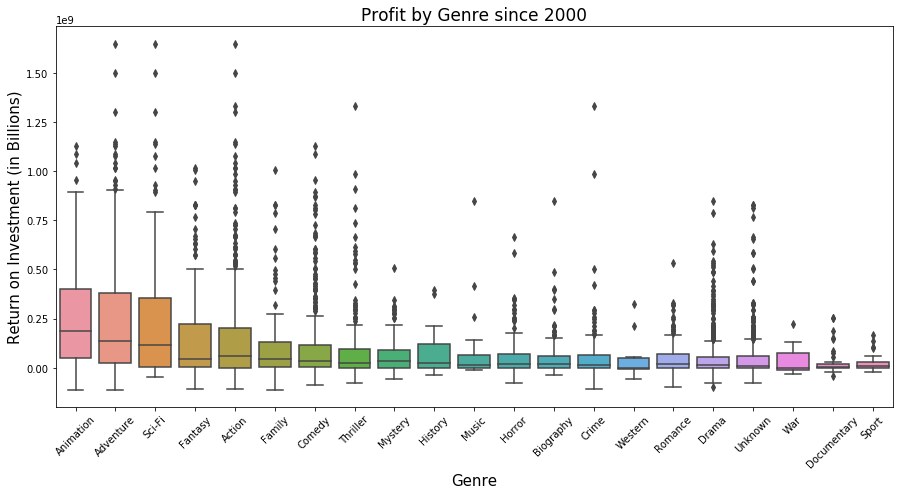

In [162]:
my_order = genre_roi_df.groupby("index")["roi"].mean().sort_values().iloc[::-1].index


plt.figure(figsize=(15, 7))

ax = sns.boxplot(x=genre_roi_df['index'], y=genre_roi_df['roi'], data=(genre_roi_df), order=my_order)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize = 10)

ax.set_title('Profit by Genre since 2000', fontsize = 17)
ax.set_xlabel('Genre', fontsize=15);
ax.set_ylabel('Return on Investment (in Billions)', fontsize=15);

## General genre return on investment breakdown (budget >$1 million,  excluded genres with fewer than 10 films in dataset)


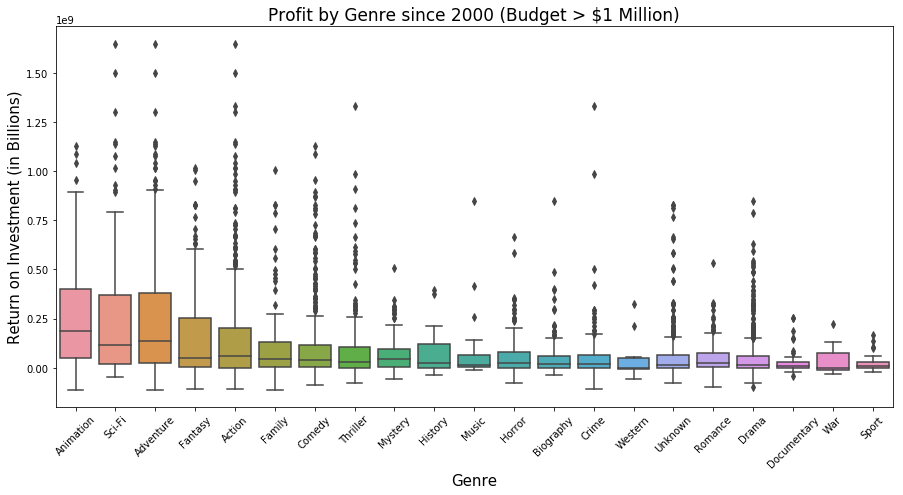

In [163]:
my_order = genre_roi1_df.groupby("index")["roi"].mean().sort_values().iloc[::-1].index


plt.figure(figsize=(15, 7))

ax = sns.boxplot(x=genre_roi1_df['index'], y=genre_roi1_df['roi'], data=(genre_roi1_df), order=my_order)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize = 10)

ax.set_title('Profit by Genre since 2000 (Budget > $1 Million)', fontsize = 17)
ax.set_xlabel('Genre', fontsize=15);
ax.set_ylabel('Return on Investment (in Billions)', fontsize=15);

## General genre return on investment breakdown (budget >$10 million,  excluded genres with fewer than 10 films in dataset)


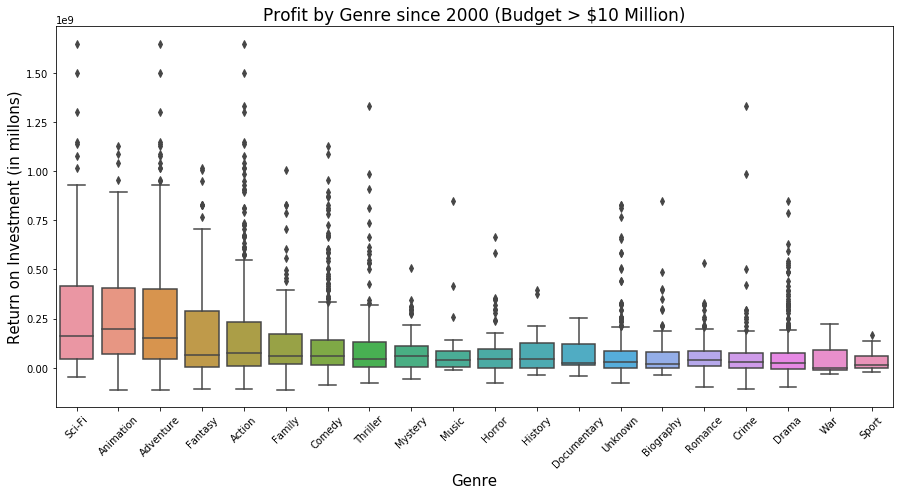

In [164]:
my_order = genre_roi10_df.groupby("index")["roi"].mean().sort_values().iloc[::-1].index


plt.figure(figsize=(15, 7))

ax = sns.boxplot(x=genre_roi10_df['index'], y=genre_roi10_df['roi'], data=(genre_roi10_df), order=my_order)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize = 10)

ax.set_title('Profit by Genre since 2000 (Budget > $10 Million)', fontsize = 17)
ax.set_xlabel('Genre', fontsize=15);
ax.set_ylabel('Return on Investment (in millons)', fontsize=15);

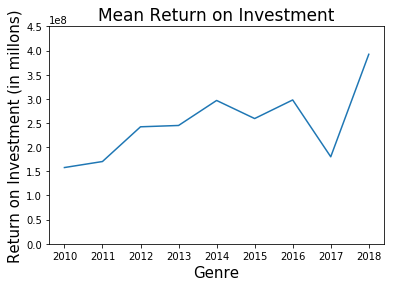

In [165]:
genre_roi2_scifi = pd.DataFrame(pd.concat([pd.Series(analysis_df_1mil.loc[analysis_df_1mil['genre1'] == 'Sci-Fi']['year'].values, analysis_df_1mil.loc[analysis_df_1mil['genre1'] == 'Sci-Fi']['roi']),
                               pd.Series(analysis_df_1mil.loc[analysis_df_1mil['genre2'] == 'Sci-Fi']['year'].values, analysis_df_1mil.loc[analysis_df_1mil['genre2'] == 'Sci-Fi']['roi']),
                               pd.Series(analysis_df_1mil.loc[analysis_df_1mil['genre3'] == 'Sci-Fi']['year'].values, analysis_df_1mil.loc[analysis_df_1mil['genre3'] == 'Sci-Fi']['roi'])]
                              )).reset_index().rename(columns={0:'year'})

grouped_mean = genre_roi2_scifi.groupby('year').mean()

ax = sns.lineplot(x= grouped_mean.index, y=grouped_mean.roi, data=grouped_mean)
plt.ylim(0, 450000000)
ax.set_title('Mean Return on Investment', fontsize = 17)
ax.set_xlabel('Genre', fontsize=15);
ax.set_ylabel('Return on Investment (in millons)', fontsize=15);

In [166]:
working_df[working_df['genres'].str.contains('Sci-Fi')]

tconst  \
start_year title                                          
2010       15 Till Midnight                   tt1568798   
           Alien Vengeance II: Rogue Element  tt1637674   
           Altitude                           tt1407049   
           Ashes                              tt1674769   
           Dark Metropolis                    tt1825735   
           Defcon 2012                        tt1349646   
           Denizen                            tt1194424   
           Disconnect                         tt0419692   
           Eyes in the Dark                   tt1561479   
           Ghost from the Machine             tt1303782   
           Glenn, the Flying Robot            tt0934446   
           Godkiller: Walk Among Us           tt1384961   
           Grey Skies                         tt1568332   
           Growth                             tt1300159   
           Hot Tub Time Machine               tt1231587   
           Hunter Prey                        tt1270291   
           Inception                          tt1375666   
           Iron Man 2                         tt1228705   
           Mars                               tt1109488   
           Monsters                           tt1470827   
           Mysterious Island                  tt1705125   
           Never Let Me Go                    tt1334260   
           Nightbeasts                        tt1513835   
           Pickman's Muse                     tt1488032   
           Predators                          tt1424381   
           Radio Free Albemuth                tt1129396   
           Re-Generator                       tt2923076   
           Repo Men                           tt1053424   
           Skyline                            tt1564585   
           Slime City Massacre                tt1401631   
...                                                 ...   
2018       Pocketman and Cargoboy             tt7625712   
           Project E.1337: ALPHA              tt5809726   
           Prospect                           tt7946422   
           Rampage                            tt2231461   
           Ready Player One                   tt1677720   
           Red Island                         tt4965146   
           Scorched Earth                     tt2392748   
           Shangri-La: Near Extinction        tt7007846   
           Snake Outta Compton                tt6987760   
           Soft Matter                        tt5891150   
           Sorry to Bother You                tt5688932   
           Starfish                           tt5700182   
           Tau                                tt4357394   
           The Dark                           tt8032572   
           The Dawnseeker                     tt8548792   
           The Domestics                      tt5591666   
           The First Purge                    tt6133466   
           The Lucky Man                      tt3458760   
           The Meg                            tt4779682   
           The Predator                       tt3829266   
           Three Worlds                       tt4347994   
           Time Jumpers                       tt8041916   
           Tinker'                            tt3833682   
           Twisted Pair                       tt8196068   
           UFO                                tt6290798   
           Upgrade                            tt6499752   
           Venom                              tt1270797   
           Violentia                          tt3446330   
           Wastelander                        tt2651724   
           Zoe                                tt6010628   

                                                            original_title_imdb  \
start_year title                                                                  
2010       15 Till Midnight                                    15 Till Midnight   
           Alien Vengeance II: Rogue Element  Alien Vengeance II: Rogue Element   

## group by runtime_minutes


In [167]:
analysis_df_runtime_grouped = analysis_df_1mil.copy()

In [168]:
analysis_df_runtime_grouped['runtime_desc'] = analysis_df_runtime_grouped.apply(
    lambda x: 'short' if x['runtime_minutes'] <= 95.0 else(
        'medium' if x['runtime_minutes'] <= 118.0 else 'long'), axis = 1
)

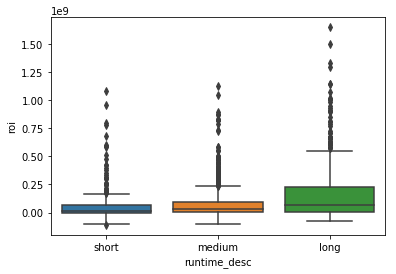

In [169]:
ax = sns.boxplot(x=analysis_df_runtime_grouped['runtime_desc'], y=analysis_df_runtime_grouped['roi'], data=analysis_df_runtime_grouped)


## Looking for trends in Adventure/Sci-Fi

In [170]:
analysis_df_1mil.loc[((analysis_df_1mil['genre3'] == 'Sci-Fi') |
                  (analysis_df_1mil['genre2'] == 'Sci-Fi') |
                  (analysis_df_1mil['genre1'] == 'Sci-Fi') )&(
                    (analysis_df_1mil['genre3'] == 'Adventure') |
                    (analysis_df_1mil['genre2'] == 'Adventure') |
                    (analysis_df_1mil['genre1'] == 'Adventure'))
                 ].sort_values(by = 'roi', ascending=False).reset_index().style.apply(
                lambda x: ['background: #00a4ef' if x.title == 'Inception' or x.title == 'Interstellar' else '' for i in x], axis = 1)

,index,year,title,runtime_minutes,genres,genre1,genre2,genre3,working_wwg,working_budget,roi
0,1392,2018,Avengers: Infinity War,149,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,2048134200,400000000,1648134200
1,949,2015,Jurassic World,124,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,1648854864,150000000,1498854864
2,474,2012,The Avengers,143,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,1517935897,220000000,1297935897
3,1397,2018,Black Panther,134,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,1347000000,200000000,1147000000
4,1439,2018,Jurassic World: Fallen Kingdom,128,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,1309500000,170000000,1139500000
5,890,2015,Avengers: Age of Ultron,141,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,1405400000,330600000,1074800000
6,581,2013,Iron Man 3,130,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,1214800000,200000000,1014800000
7,344,2011,Transformers: Dark of the Moon,154,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,1123800000,195000000,928800000
8,1086,2016,Captain America: Civil War,147,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,1153300000,250000000,903300000
9,865,2014,Transformers: Age of Extinction,165,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,1104000000,210000000,894000000


Christopher Nolan movies are the only non-lisenced films on the list until number 49 - Paul